In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

def read_csv(file_loc: str) -> pd.DataFrame:
    return pd.read_csv(file_loc, true_values=["resolved"], false_values=["floor"], na_values=[''])

df = pd.concat([read_csv("file_3_Mar18_Output_1.csv"), read_csv("file_3_Mar18_Output_1.csv")], ignore_index=True)

In [3]:
df["account_open_date_13_march"] = pd.to_datetime(df["account_open_date_13_march"])
df["account_open_date_18_march"] = pd.to_datetime(df["account_open_date_18_march"])

# Cleanup
df[["delinquency_history_13_march_present", "delinquency_history_18_march_present"]] = df[["delinquency_history_13_march", "delinquency_history_18_march"]].map(lambda x: int(str(x)[1]))
df[["delinquency_history_13_march_past", "delinquency_history_18_march_past"]] = df[["delinquency_history_13_march", "delinquency_history_18_march"]].map(lambda x: int(str(x)[2]))
df[["ebill_enrolled_status_13_march", "ebill_enrolled_status_18_march"]] =  df[["ebill_enrolled_status_13_march", "ebill_enrolled_status_18_march"]].fillna("NA").replace(r"^\s*$", "NA", regex=True)
df[["account_status_13_march", "account_status_18_march"]] =  df[["account_status_13_march", "account_status_18_march"]].fillna("NA").replace(r"^\s*$", "NA", regex=True)
df[["card_activation_status_13_march", "card_activation_status_18_march"]] = df[["card_activation_status_13_march", "card_activation_status_18_march"]].fillna(-1).replace(r"^\s*$", -1, regex=True)
min_date = min(min(df["account_open_date_13_march"]), min(df["account_open_date_18_march"]))
df["account_open_date_13_march"] = np.log((df["account_open_date_13_march"] - min_date).astype('int64') + 1)
df["account_open_date_18_march"] = np.log((df["account_open_date_18_march"] - min_date).astype('int64') + 1)
df[["day", "time_of_day"]] = df["timestamp_call_key"].str.split(" ").str[0].str.extract(r'(\d{6})(\d{6})')

# add mos in order
col_names = [f"mos{i}" for i in range(1, len(max(df["mos"], key=lambda x: len(x.split()))) // 3 + 2)]
split_mos = df["mos"].str.split(expand=True)
split_mos = split_mos.fillna("NA")
split_mos.columns = col_names[:len(split_mos.columns)]

# transform reasons/mos
reason_encoder = LabelEncoder()
reason_encoder = reason_encoder.fit(["AA", "AG", "AL", "AP", "AR", "AS", "AT", "AU", "BA", "Ba", "BL", "CA", "CB", "CC",
"CD", "CS", "CT", "CX", "DA", "DB", "DE", "DP", "DR", "DS", "eA", "eB", "EB", "eL", "eP", "eR", "ER", "eS", "eY", "FB", "FD",
"FI", "FM", "GA", "HI", "iA", "IA", "iB", "iC", "IC", "IE", "iF", "iL", "iM", "iO", "iP", "IR", "iR", "iS", "iT", "IV","LC",
"LM", "LS", "Ls", "LW", "m-", "ma", "me", "MF", "mm", "mn", "mo", "mp", "MP", "Mr", "MR", "mt", "nl", "NU", "OB", "OC", "OI", "OO",
"OR", "OV", "PA", "PC", "Pd", "PF", "PH", "PI", "PO", "PP", "PR", "PS", "PT", "PV", "PX", "Py", "RC", "RI", "RP", "RS", "RV", "SA",
"SP", "SR", "ss", "ST", "Ta", "TA", "TB", "TC", "TD", "Te", "TE", "Tf", "TF", "TL", "TN", "TP", "TR", "TS", "TU", "UP", "VP", "VR",
"WA", "wa", "rP", "P1", "P2", "S1", "S2", "S3", "P3", "C1", "C2", "P4", "P5", "P6", "rT", "T1", "A1", "A2", "T2", "T3", "D1", "D2",
"D3", "D4", "FR", "PD", "OL", "NO", "XR", "VA", "mP", "AM", "NA"])
df["reason"] = reason_encoder.transform(df["reason"])
for col in split_mos.columns:
    split_mos[col] = reason_encoder.transform(split_mos[col])

df = pd.concat([df, split_mos], axis=1)

# transform account status
external_status_encoder = LabelEncoder()
encoded_status_codes = external_status_encoder.fit_transform(df["account_status_18_march"])
df["account_status_18_march"] = encoded_status_codes
df["account_status_13_march"] = encoded_status_codes

# transform ebill status
ebill_encoder = LabelEncoder()
encoded_ebill_status = ebill_encoder.fit_transform(df["ebill_enrolled_status_18_march"])
df["ebill_enrolled_status_18_march"] = encoded_ebill_status
df["ebill_enrolled_status_13_march"] = encoded_ebill_status

df = df.drop(["delinquency_history_13_march", "delinquency_history_18_march"], axis=1)
df

,timestamp_call_key,retailer_code,serial,reason,mos,resolved,no_of_accounts_with_syf_13_march,account_balance_13_march,account_open_date_13_march,account_status_13_march,...,mos2,mos3,mos4,mos5,mos6,mos7,mos8,mos9,mos10,mos11
0,240315173250 DAL1OA3M,D,10010009499,79,IA PP TR,True,1.0,NaN,42.040285,7,...,79,111,56,56,56,56,56,56,56,56
1,240315124742 DAL15XHK,E,10006021998,11,IA BA TS nl TR,False,2.0,143.28,41.856014,7,...,11,112,150,111,56,56,56,56,56,56
2,240317114237 DAL3BLK6,J,10016007830,82,IA AA BA MR nl PT TR,True,12.0,0.00,42.112479,7,...,2,11,54,150,82,111,56,56,56,56
3,240314120849 PHX6PL4U,E,10008003199,11,IA BA,True,2.0,44.98,42.211587,7,...,11,56,56,56,56,56,56,56,56,56
4,240314145902 DAL68RYS,I,10013002037,11,IA BA TS nl mm TR,False,6.0,7.00,42.180308,7,...,11,112,150,145,111,56,56,56,56,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809261,240315165941 PHX67C7R,E,10008016957,82,IA BA nl PT TR,True,6.0,4431.60,41.924628,3,...,11,150,82,111,56,56,56,56,56,56
1809262,240315180137 PHX2GWK4,B,10002066257,11,IA PP BA,True,3.0,100.54,42.193453,7,...,79,11,56,56,56,56,56,56,56,56
1809263,240314142306 DAL33PKW,E,10008004931,11,IA BA,True,2.0,2504.35,42.204972,7,...,11,56,56,56,56,56,56,56,56,56
1809264,240314141352 DAL64P9X,F,10009002991,79,IA IA PP TR,True,5.0,2934.35,42.188158,7,...,42,79,111,56,56,56,56,56,56,56


In [4]:
df.dropna().describe()

,serial,reason,no_of_accounts_with_syf_13_march,account_balance_13_march,account_open_date_13_march,account_status_13_march,eservice_ind_13_march,ebill_enrolled_status_13_march,auto_pay_enrolled_status_13_march,no_of_accounts_with_syf_18_march,...,mos2,mos3,mos4,mos5,mos6,mos7,mos8,mos9,mos10,mos11
count,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,...,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06
mean,1.000573e+10,5.169996e+01,5.099463e+00,1.177640e+03,4.212144e+01,6.863517e+00,4.276377e-01,3.163588e+00,1.589406e-02,5.109123e+00,...,5.215805e+01,6.908406e+01,7.679898e+01,7.792403e+01,7.051071e+01,6.675572e+01,6.206624e+01,5.917222e+01,5.755828e+01,5.674363e+01
std,5.773595e+06,3.595429e+01,3.609405e+00,1.794959e+03,1.467186e-01,7.737351e-01,4.947361e-01,8.672018e-01,1.250658e-01,3.613249e+00,...,2.848891e+01,4.223605e+01,3.966408e+01,3.930796e+01,3.329907e+01,2.702412e+01,2.051350e+01,1.503050e+01,1.073185e+01,7.498497e+00
min,1.000100e+10,2.000000e+00,1.000000e+00,-2.302494e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00
25%,1.000203e+10,1.100000e+01,2.000000e+00,1.141600e+02,4.209411e+01,7.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,...,4.200000e+01,1.100000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01
50%,1.000400e+10,7.900000e+01,4.000000e+00,4.660800e+02,4.215846e+01,7.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,4.000000e+00,...,4.200000e+01,7.900000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01
75%,1.000703e+10,7.900000e+01,7.000000e+00,1.478030e+03,4.219099e+01,7.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,7.000000e+00,...,7.900000e+01,1.110000e+02,1.110000e+02,1.110000e+02,8.200000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01
max,1.005400e+10,1.540000e+02,1.210000e+02,4.000043e+04,4.221291e+01,9.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.210000e+02,...,1.500000e+02,1.500000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02


In [5]:
agg = df.groupby(["reason"])
agg.groups


{2: [270, 271, 311, 357, 495, 696, 741, 790, 1044, 1099, 1100, 1112, 1217, 1252, 1421, 1578, 1617, 2154, 2224, 2229, 2237, 2386, 2553, 2557, 2561, 2622, 2623, 2624, 2703, 2777, 2919, 2920, 2940, 2987, 3060, 3085, 3138, 3161, 3162, 3163, 3302, 3391, 3432, 3446, 3465, 3753, 3842, 3870, 3952, 4045, 4068, 4687, 4728, 4747, 4834, 4863, 4895, 4986, 5245, 5545, 5710, 5791, 5792, 5793, 5927, 6031, 6050, 6051, 6065, 6142, 6143, 6209, 6297, 6450, 6734, 6880, 6899, 6900, 6915, 6998, 7019, 7135, 7156, 7161, 7221, 7233, 7286, 7287, 7328, 7798, 7849, 7915, 8024, 8088, 8159, 8178, 8488, 8673, 8739, 8740, ...], 6: [38, 198, 247, 408, 586, 1290, 1298, 1795, 1898, 2477, 2478, 2583, 2593, 2647, 2957, 3333, 3407, 3926, 4274, 4486, 4490, 4884, 4885, 4907, 5323, 5757, 5801, 6126, 6221, 6284, 6497, 6514, 6834, 7202, 7368, 7395, 9046, 10311, 10368, 10457, 10600, 11636, 11891, 12243, 13150, 13597, 13645, 13975, 14004, 14425, 14683, 15175, 15811, 15904, 15942, 16538, 16881, 16955, 17140, 17378, 17537, 17808, 17

In [7]:
agg_mean = agg.mean(numeric_only=True)
agg_mean

,serial,resolved,no_of_accounts_with_syf_13_march,account_balance_13_march,account_open_date_13_march,account_status_13_march,eservice_ind_13_march,ebill_enrolled_status_13_march,auto_pay_enrolled_status_13_march,no_of_accounts_with_syf_18_march,...,mos2,mos3,mos4,mos5,mos6,mos7,mos8,mos9,mos10,mos11
reason,,,,,,,,,,,,,,,,,,,,,
2,1.000532e+10,0.540668,5.221481,812.861093,42.158119,6.857982,0.382010,3.043261,0.021043,5.266013,...,9.120388,65.965548,54.978859,64.939904,67.739258,61.073505,59.033474,57.603210,56.926495,56.365078
6,1.000579e+10,0.286792,4.485687,727.860694,42.117763,6.801887,0.478931,3.089308,0.031447,4.514627,...,43.216352,47.918239,95.774528,96.752201,69.941509,83.382390,70.655660,64.818239,60.695912,58.697484
9,1.000509e+10,0.872390,5.688402,1010.572266,42.140247,6.949361,0.694036,2.685475,0.055102,5.696982,...,39.864166,39.437544,97.271020,106.537837,58.987937,67.045581,63.495473,61.320103,59.245778,57.812930
10,1.000732e+10,0.571429,8.714286,32.377143,42.071977,3.428571,0.428571,2.857143,0.000000,8.857143,...,139.571429,72.142857,34.571429,114.857143,68.857143,104.142857,47.428571,67.428571,42.857143,63.857143
11,1.000572e+10,0.764139,5.119245,1189.518918,42.128047,6.838697,0.468315,3.054011,0.023741,5.129624,...,38.977101,44.868162,72.364360,79.242095,72.059147,66.461018,62.076037,59.107256,57.255782,56.437710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1.000578e+10,0.089147,4.517442,772.986101,42.077017,6.797481,0.524225,2.698643,0.027132,4.535853,...,42.986434,47.640504,96.982558,131.873062,128.064922,105.458333,81.777132,70.000969,63.470930,60.461240
145,1.000501e+10,1.000000,4.000000,NaN,42.198476,7.000000,0.000000,4.000000,0.000000,4.000000,...,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
146,1.000651e+10,0.335046,4.271326,1187.710155,42.167541,6.584789,0.580678,2.806783,0.035971,4.290853,...,42.855087,77.279548,57.801644,52.610483,52.032888,51.941418,71.811922,56.339157,56.000000,56.000000


/var/folders/zt/xw07jssn51105y3y4yjl61540000gn/T/ipykernel_79011/3293557184.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure( figsize=(30, 6))


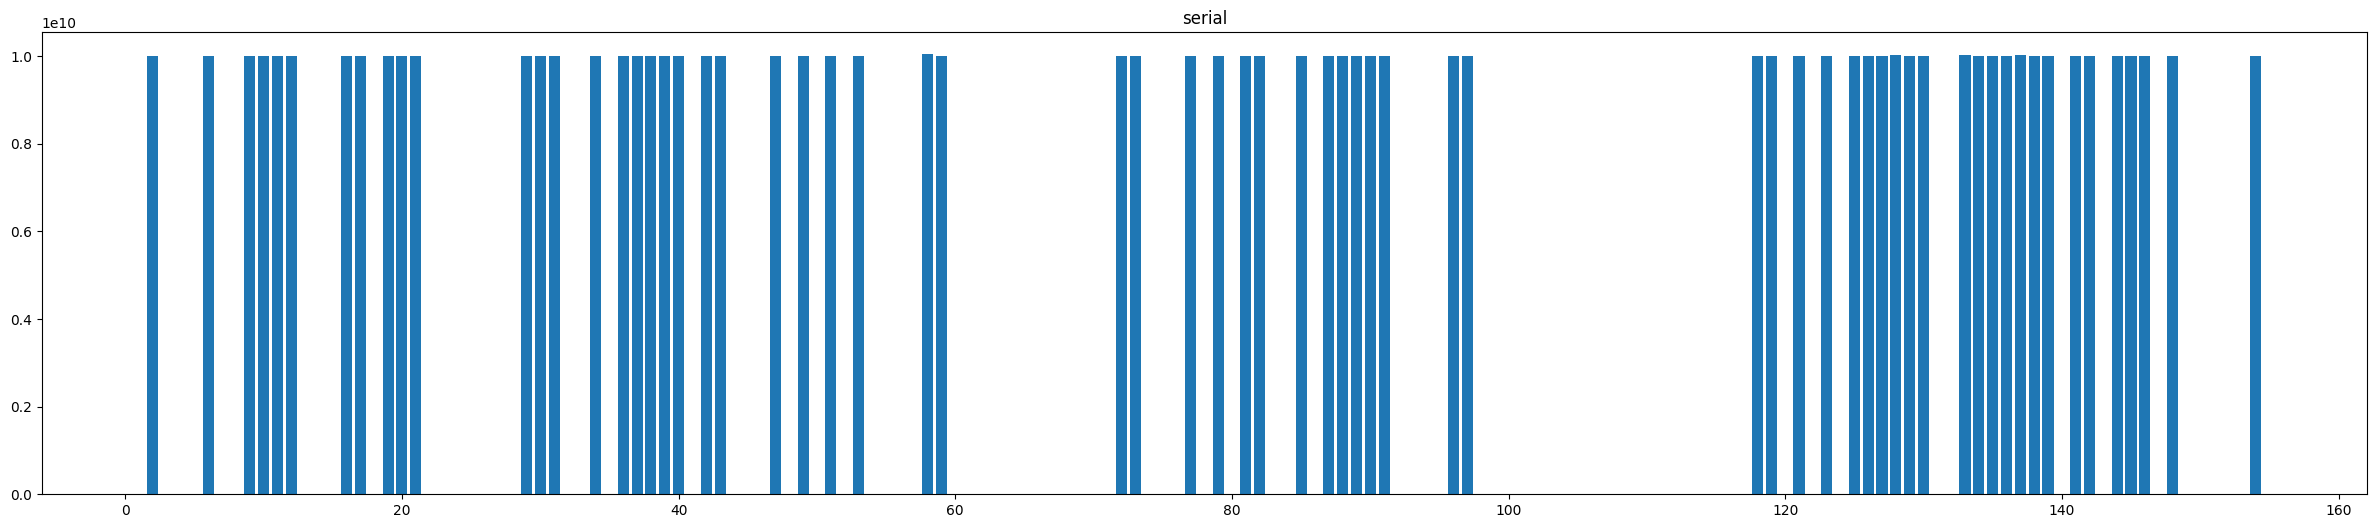

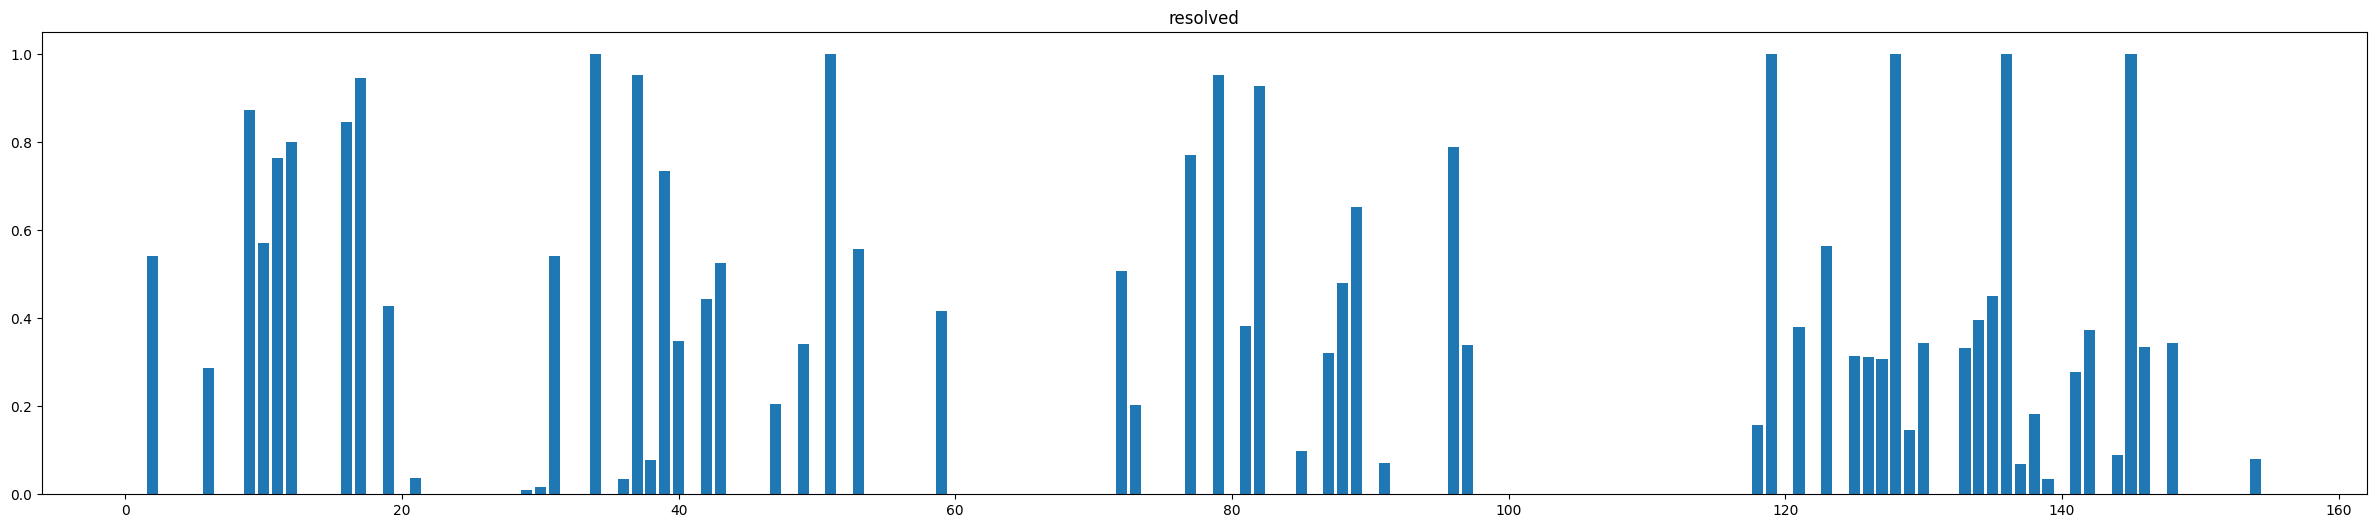

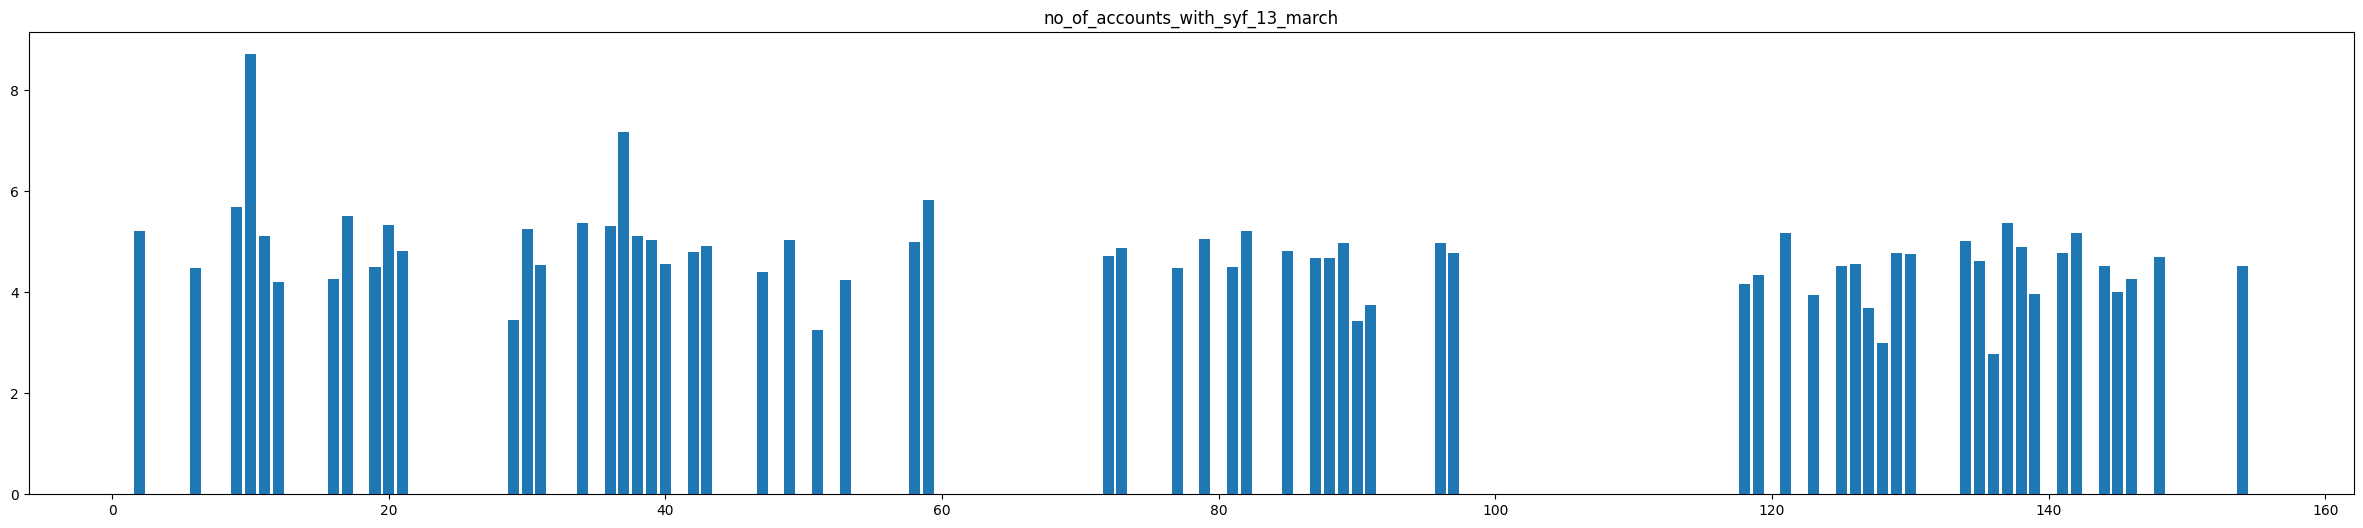

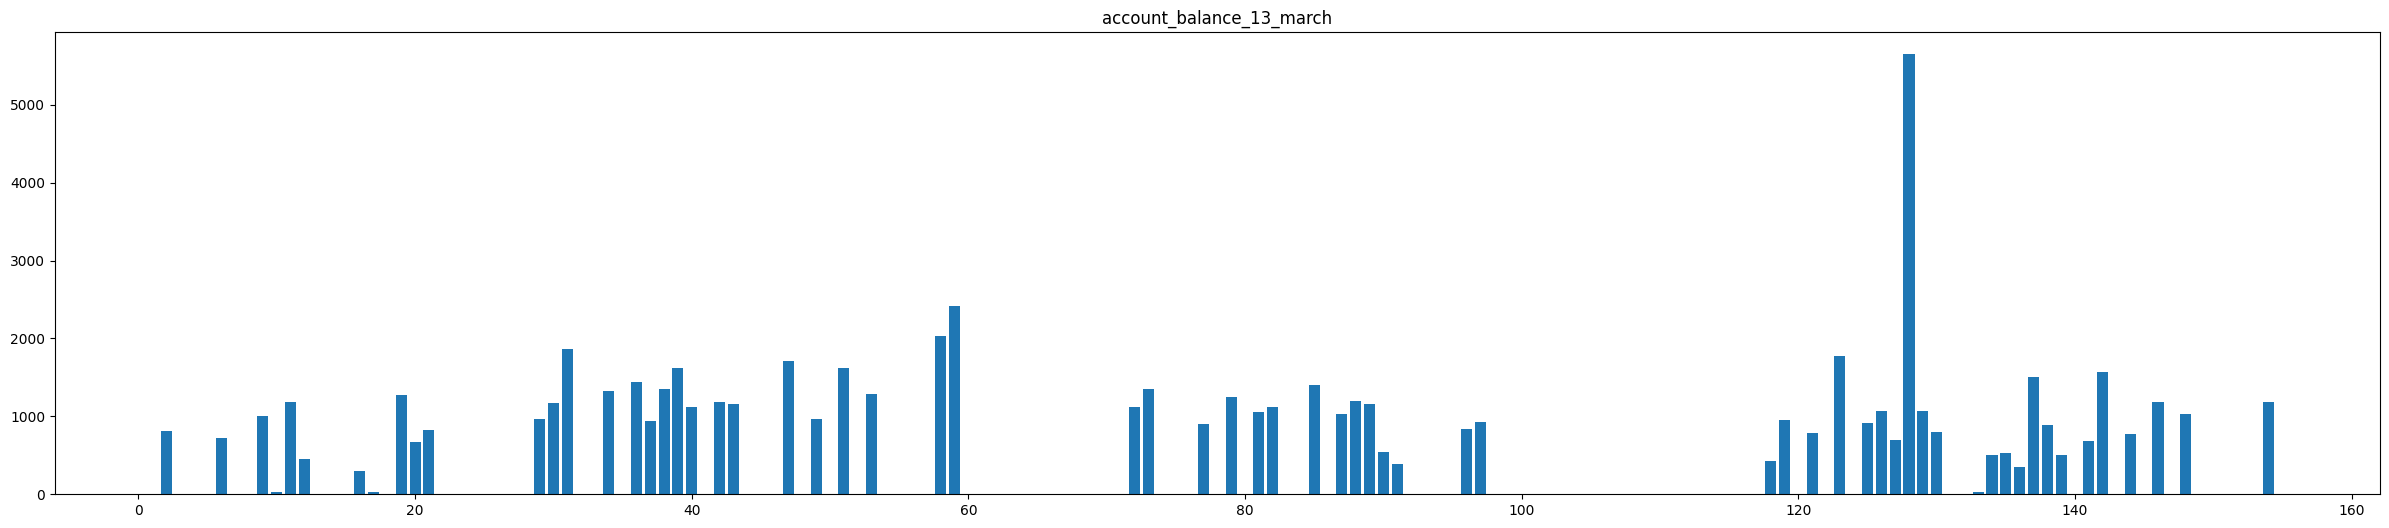

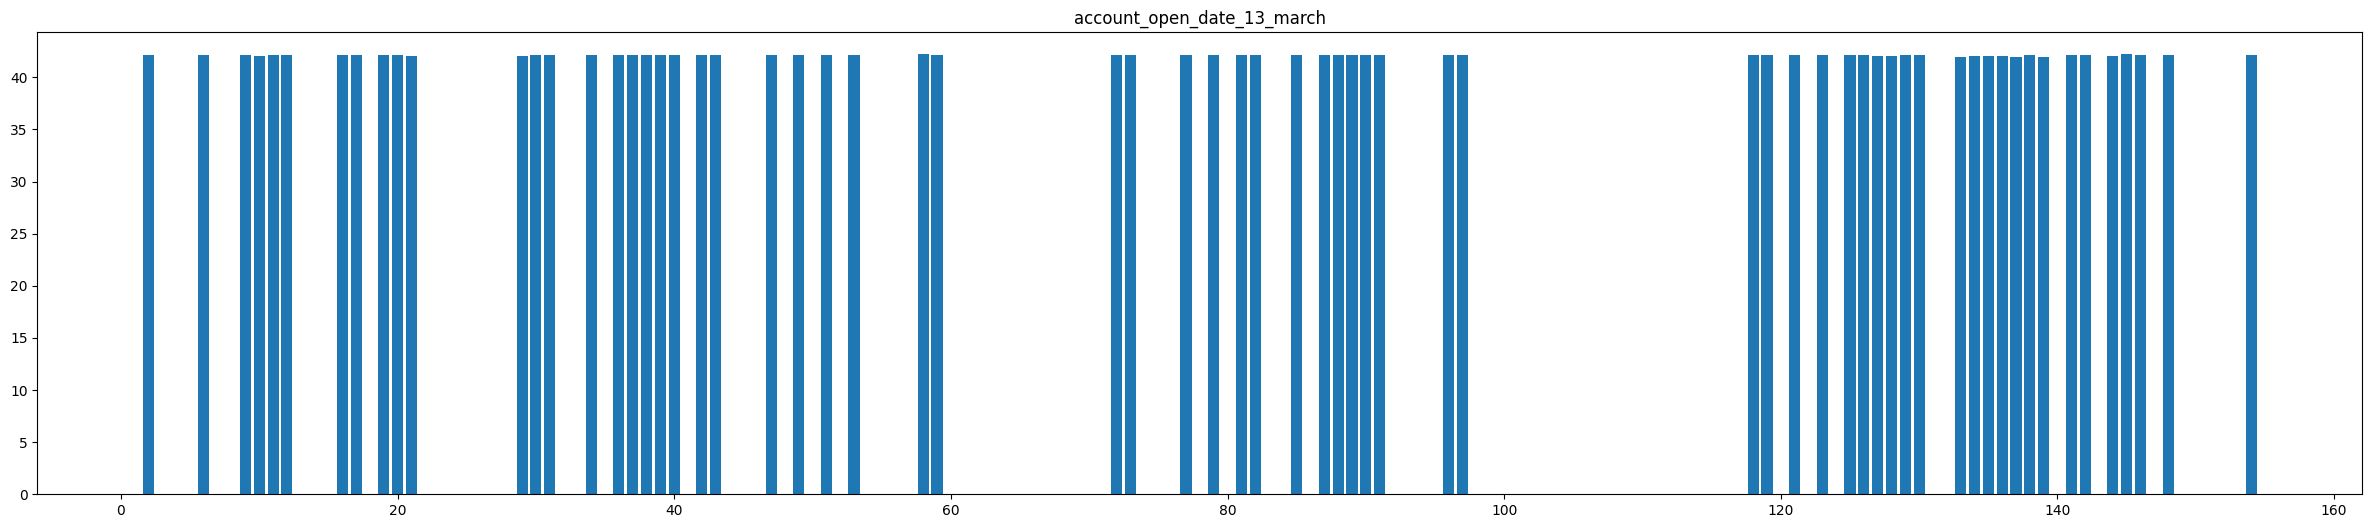

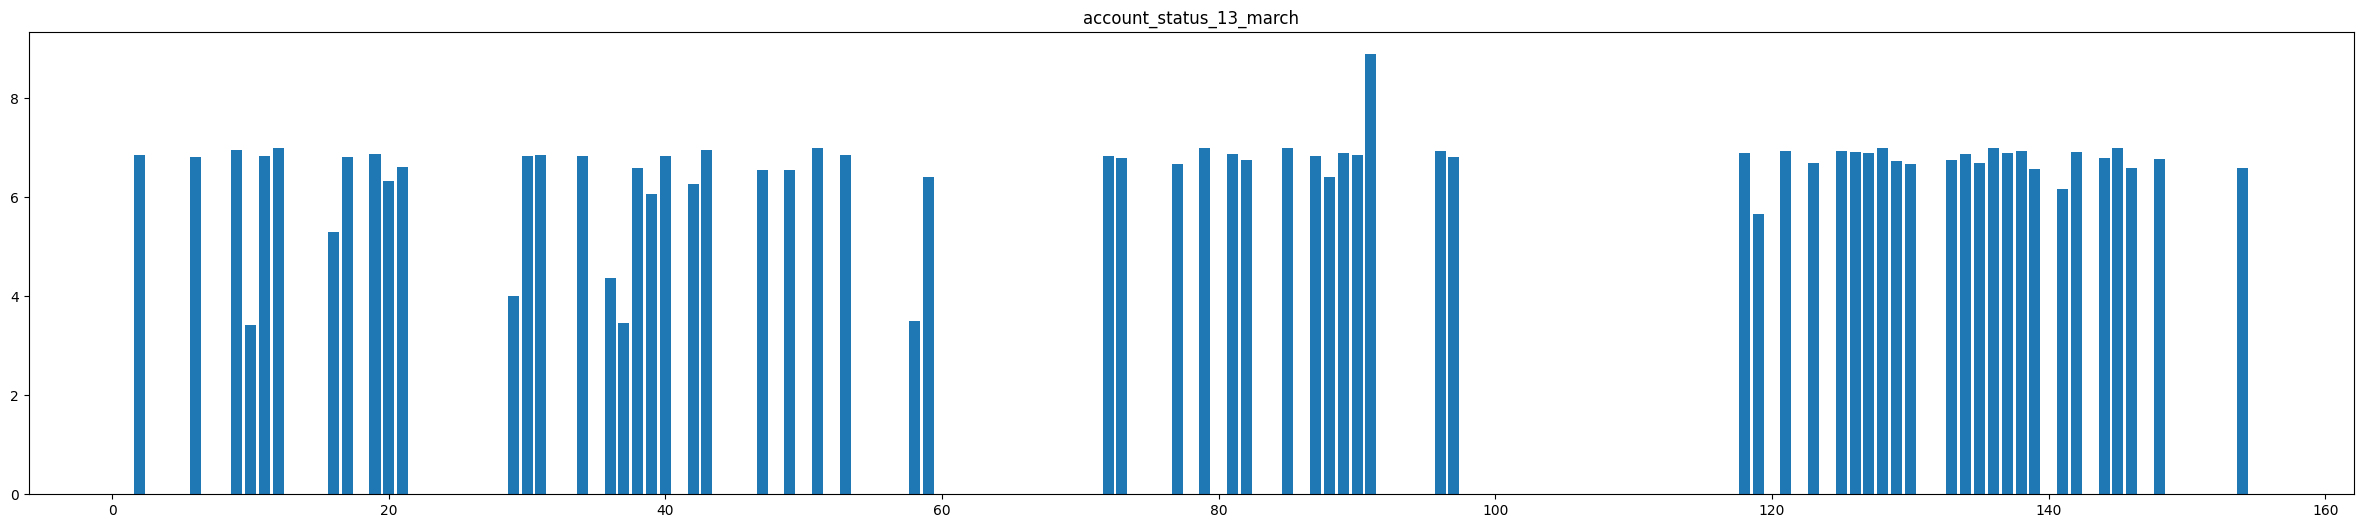

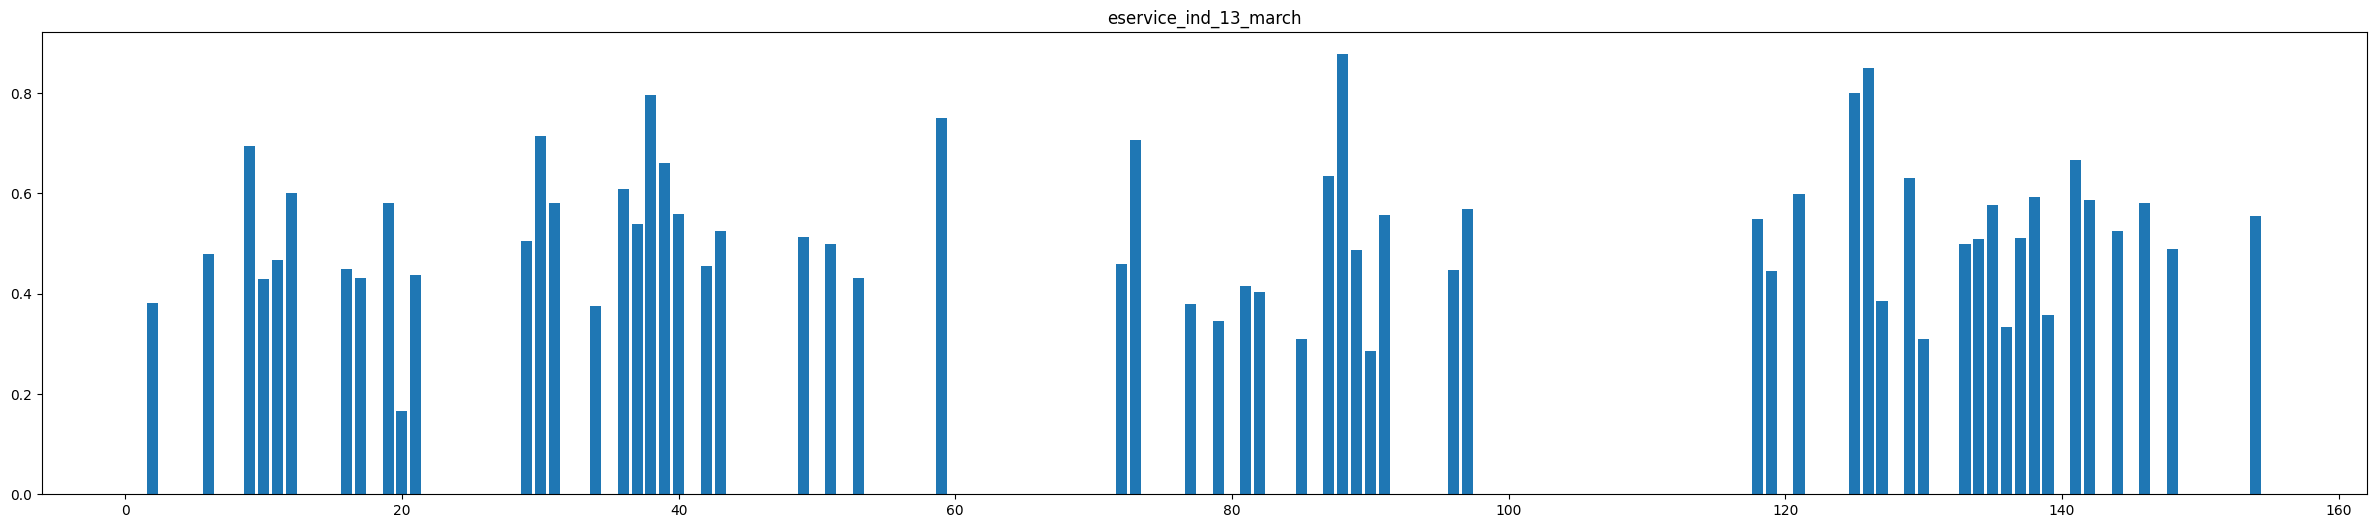

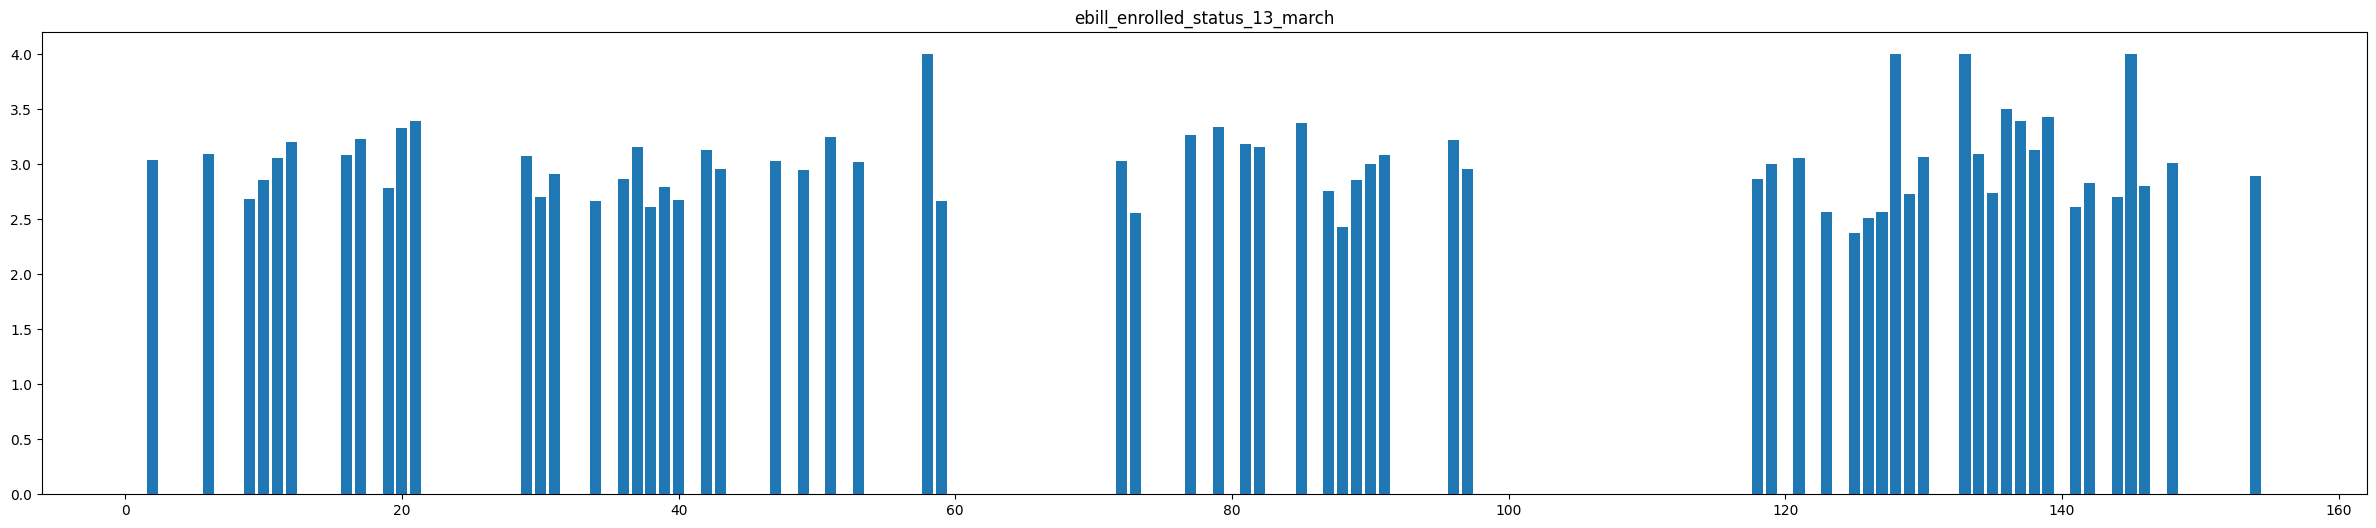

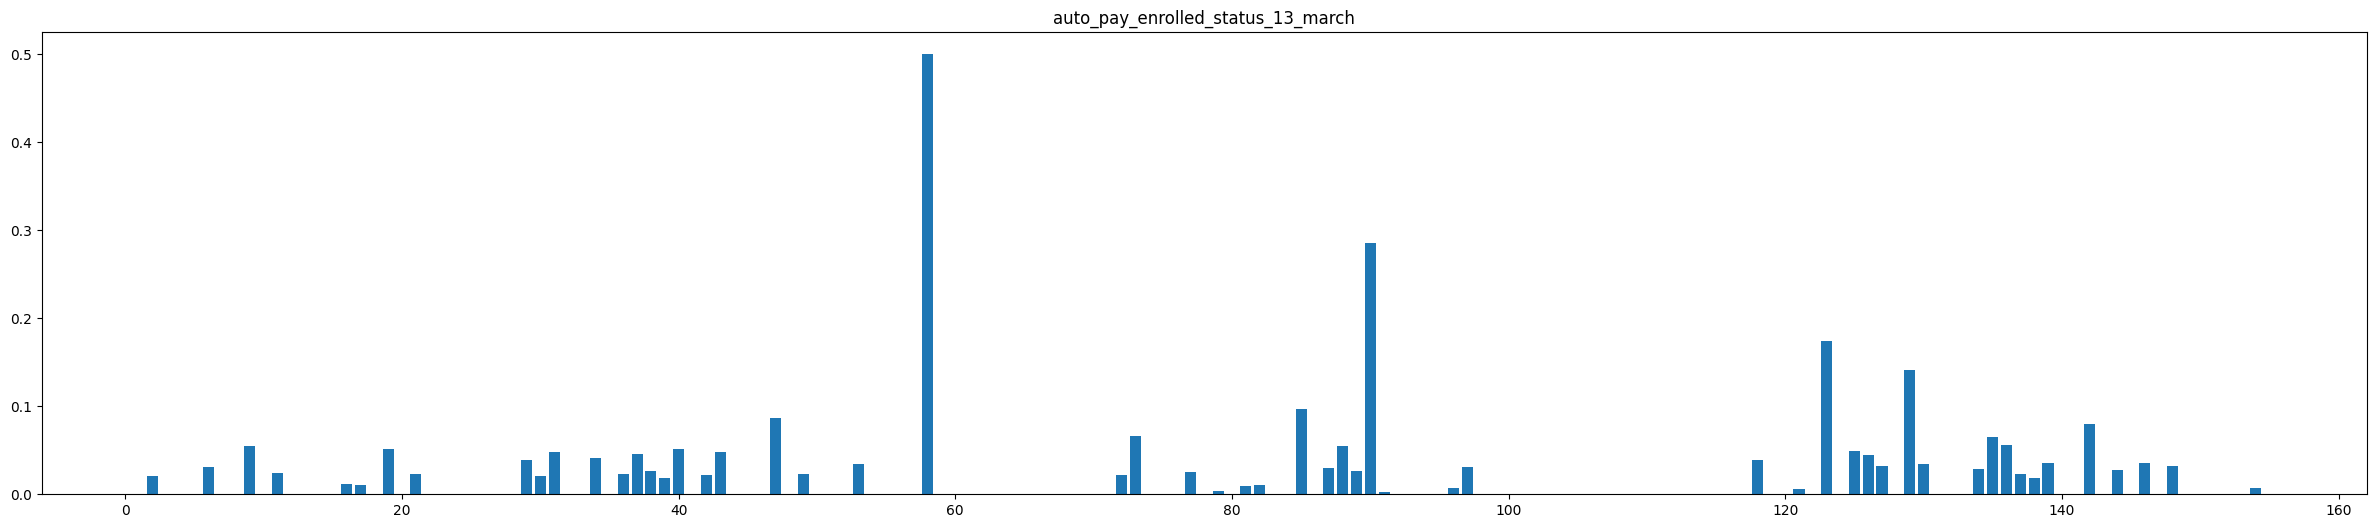

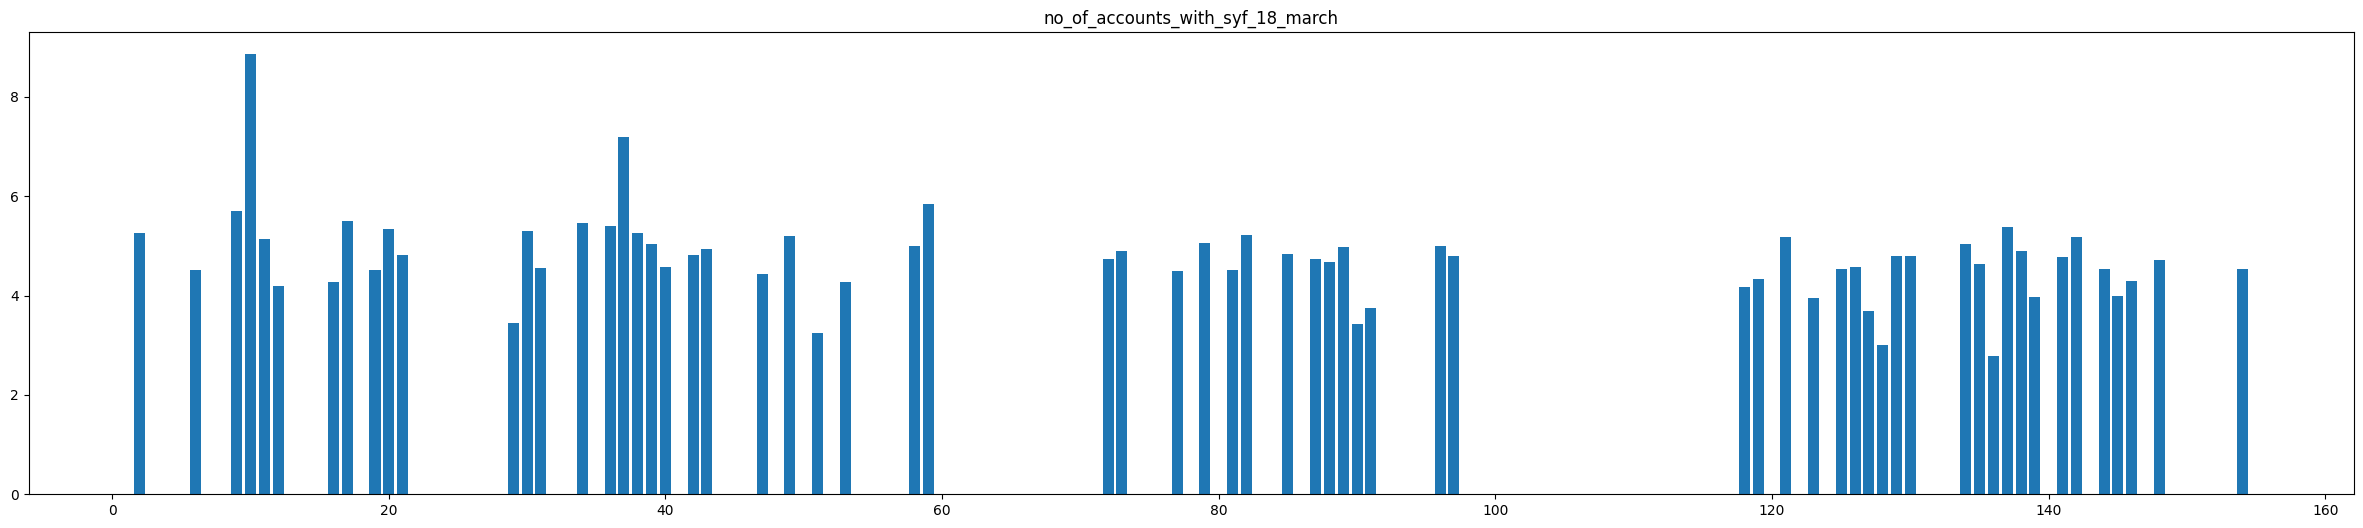

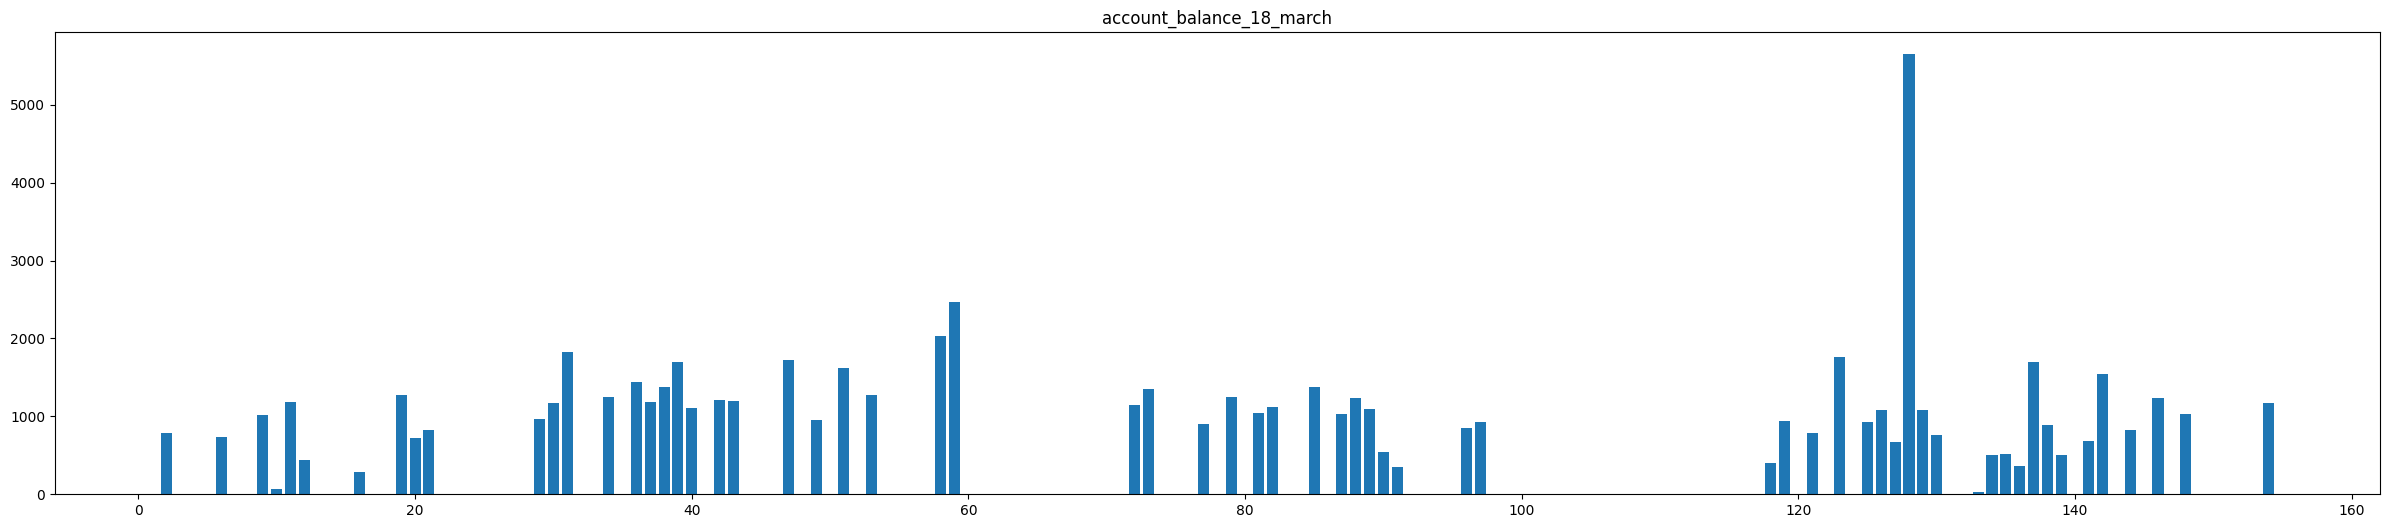

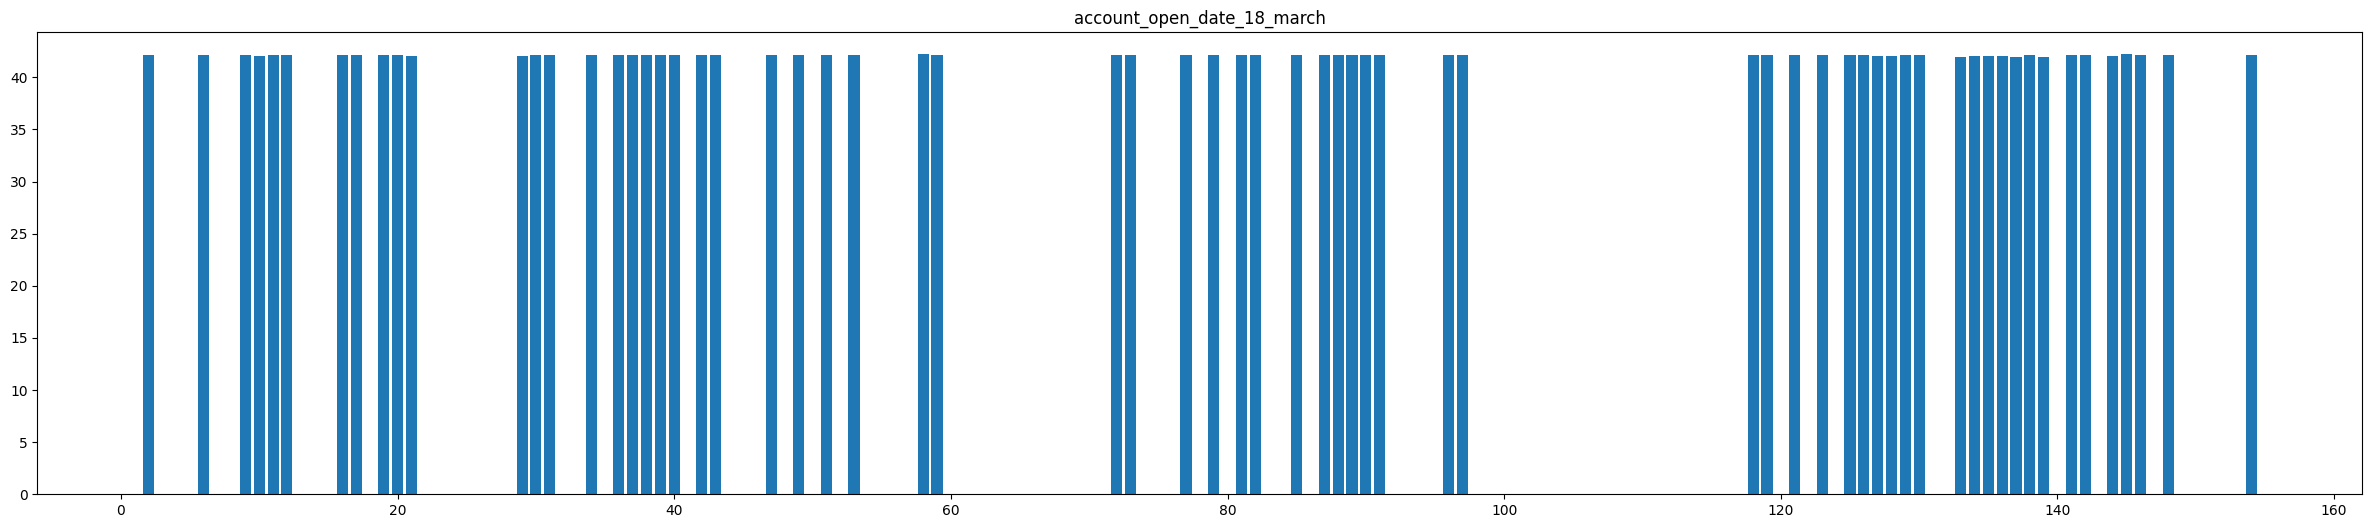

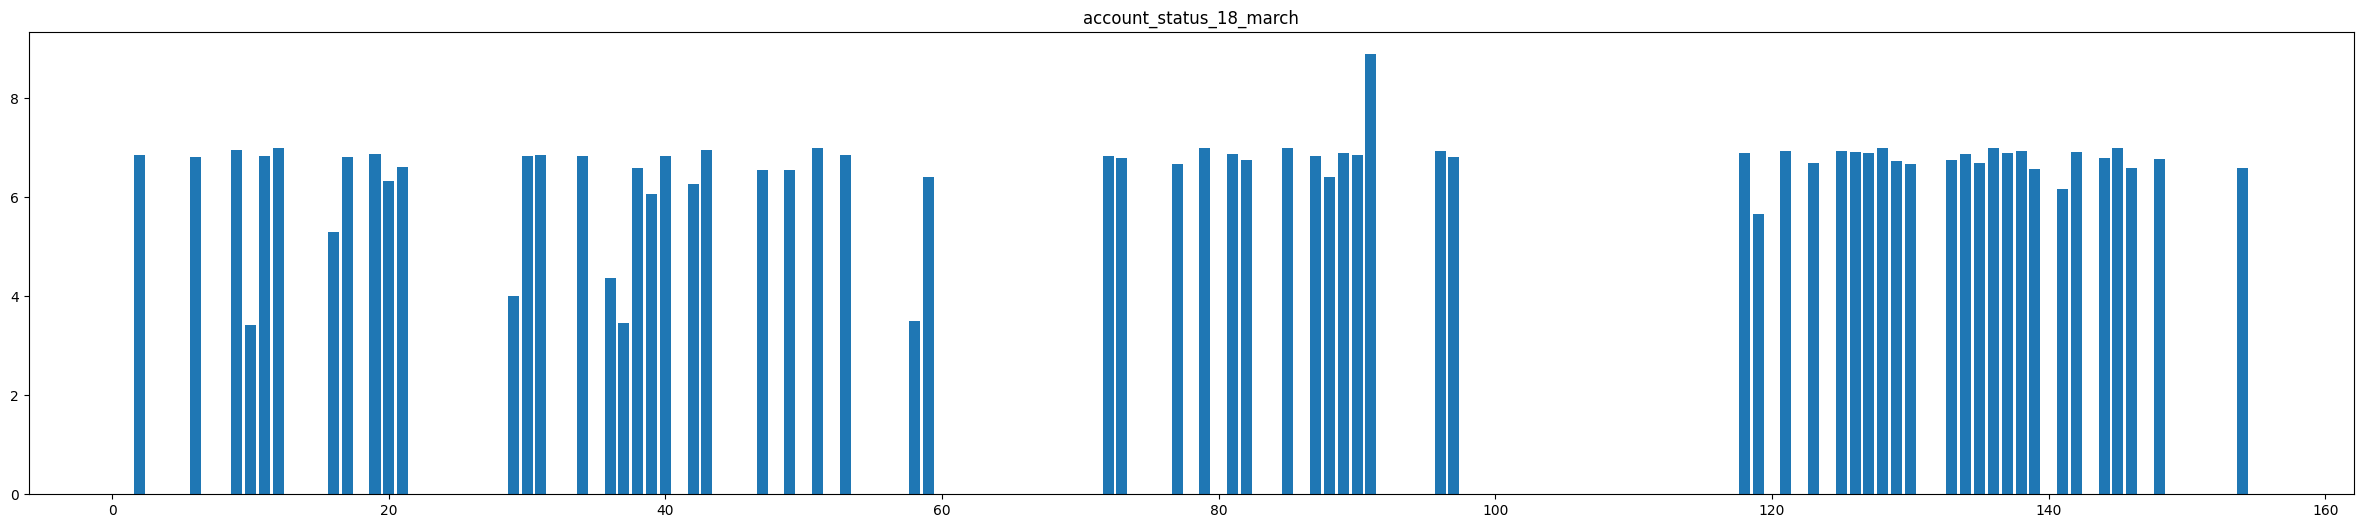

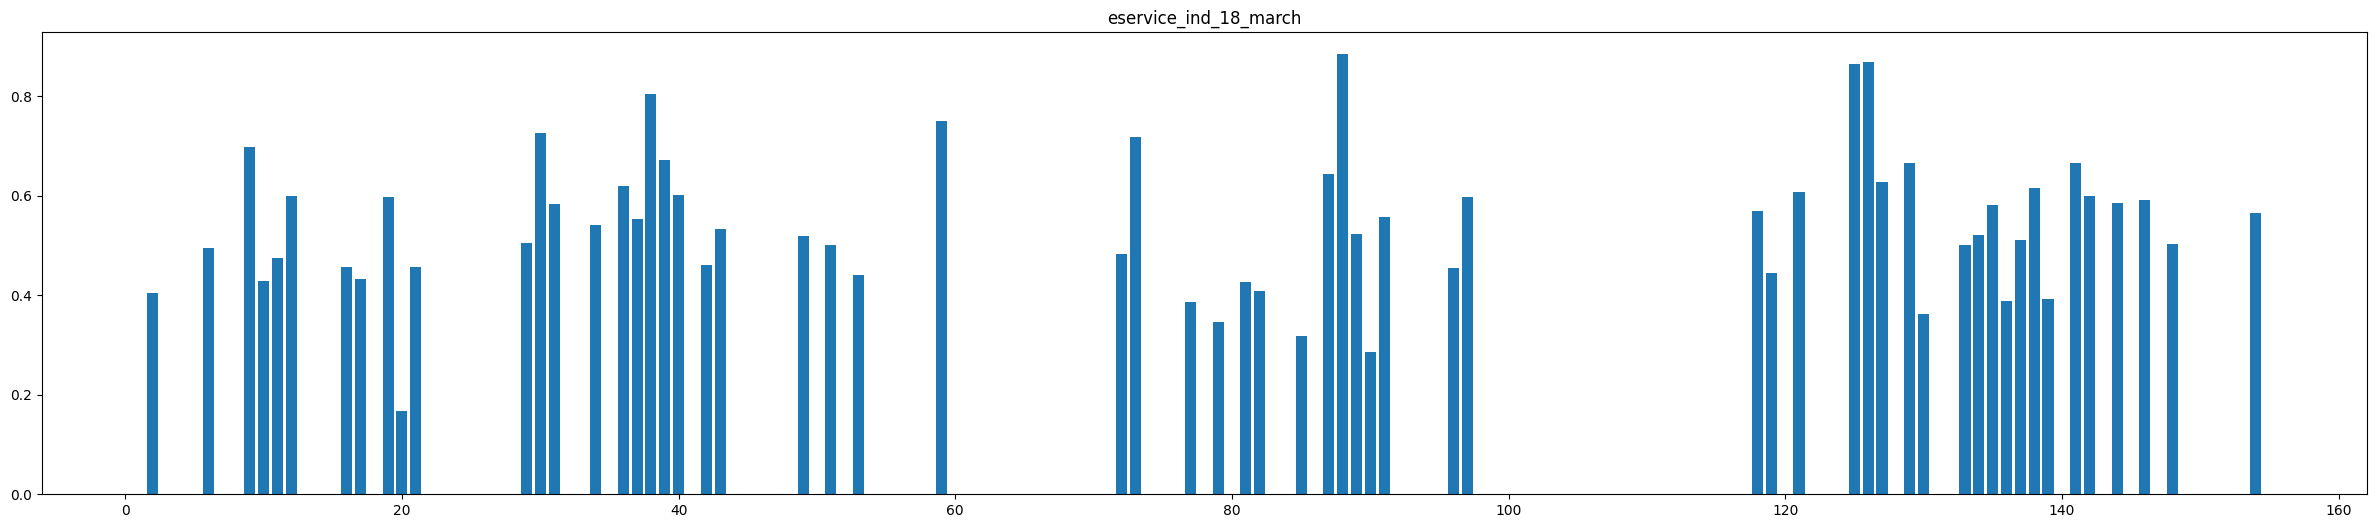

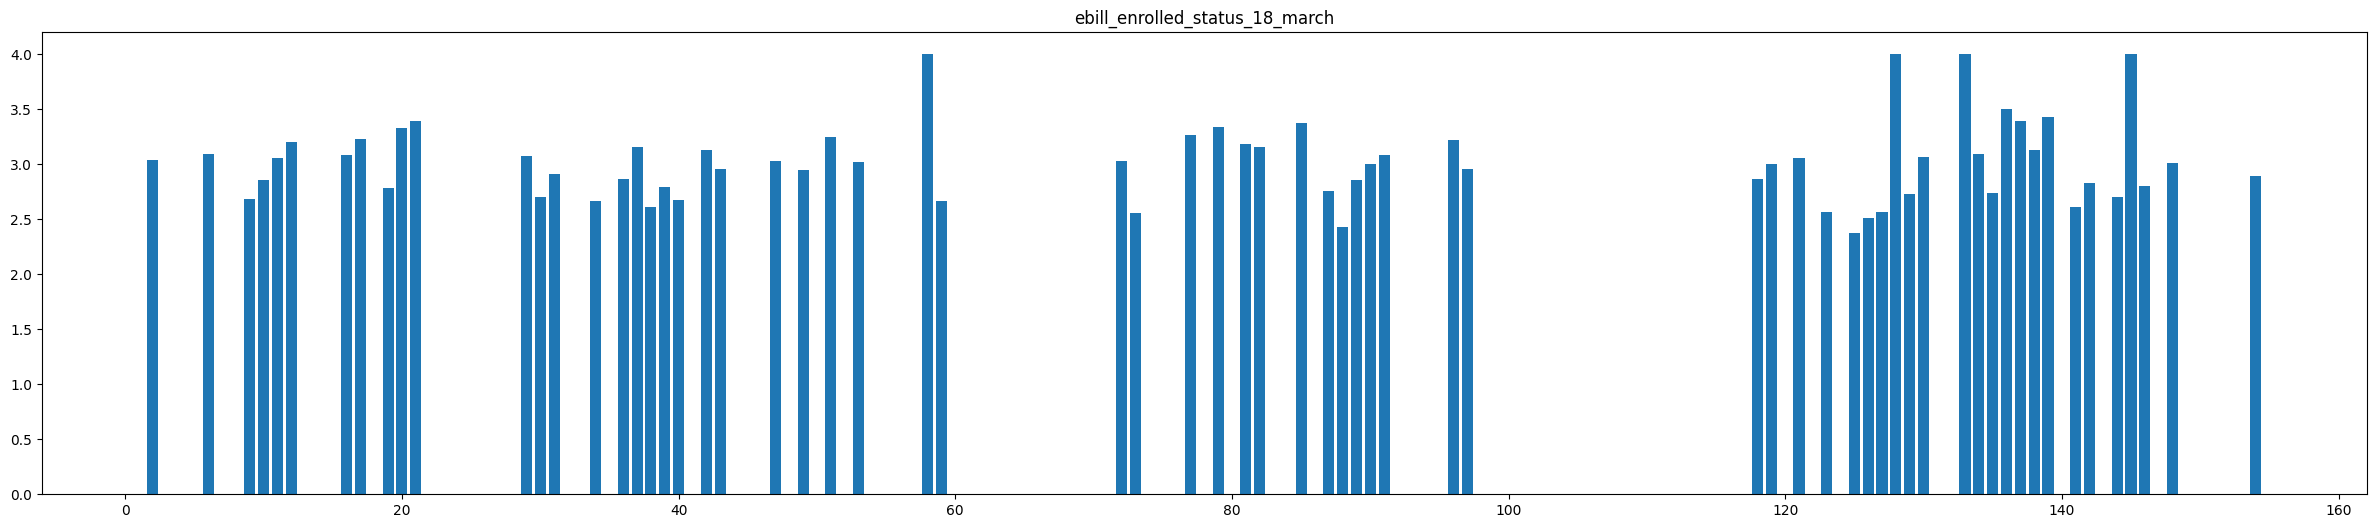

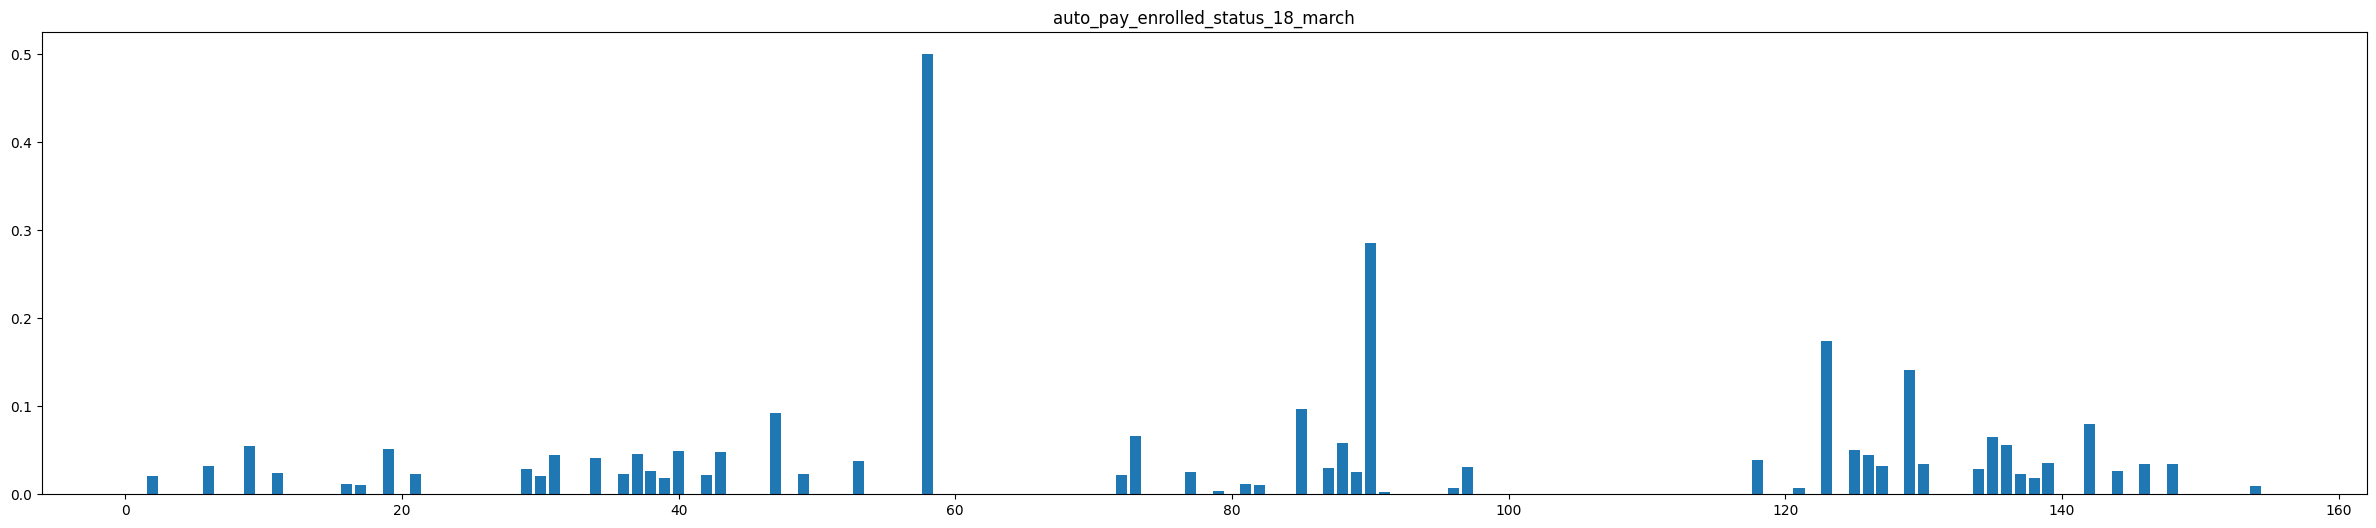

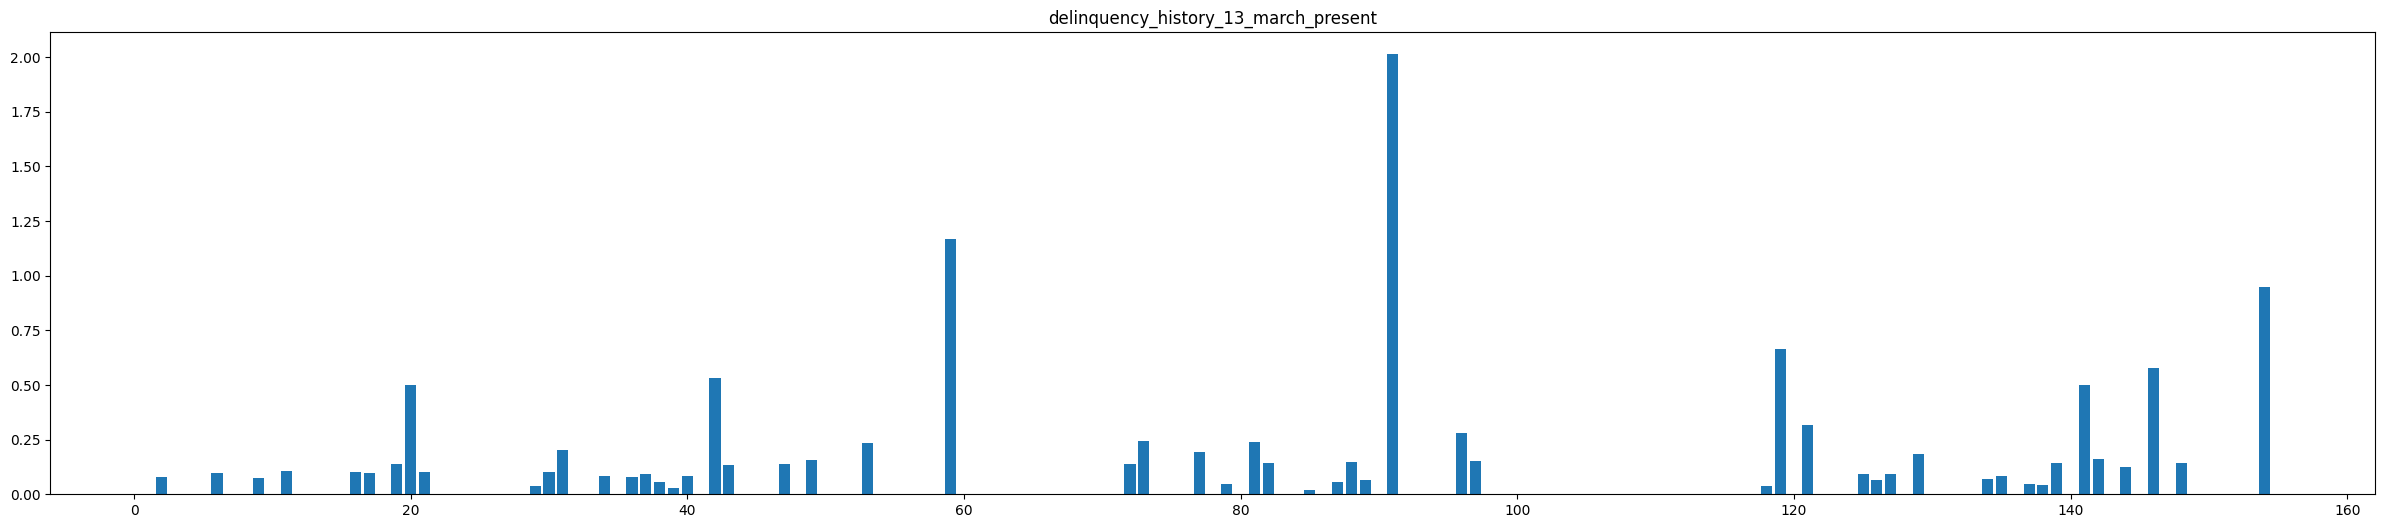

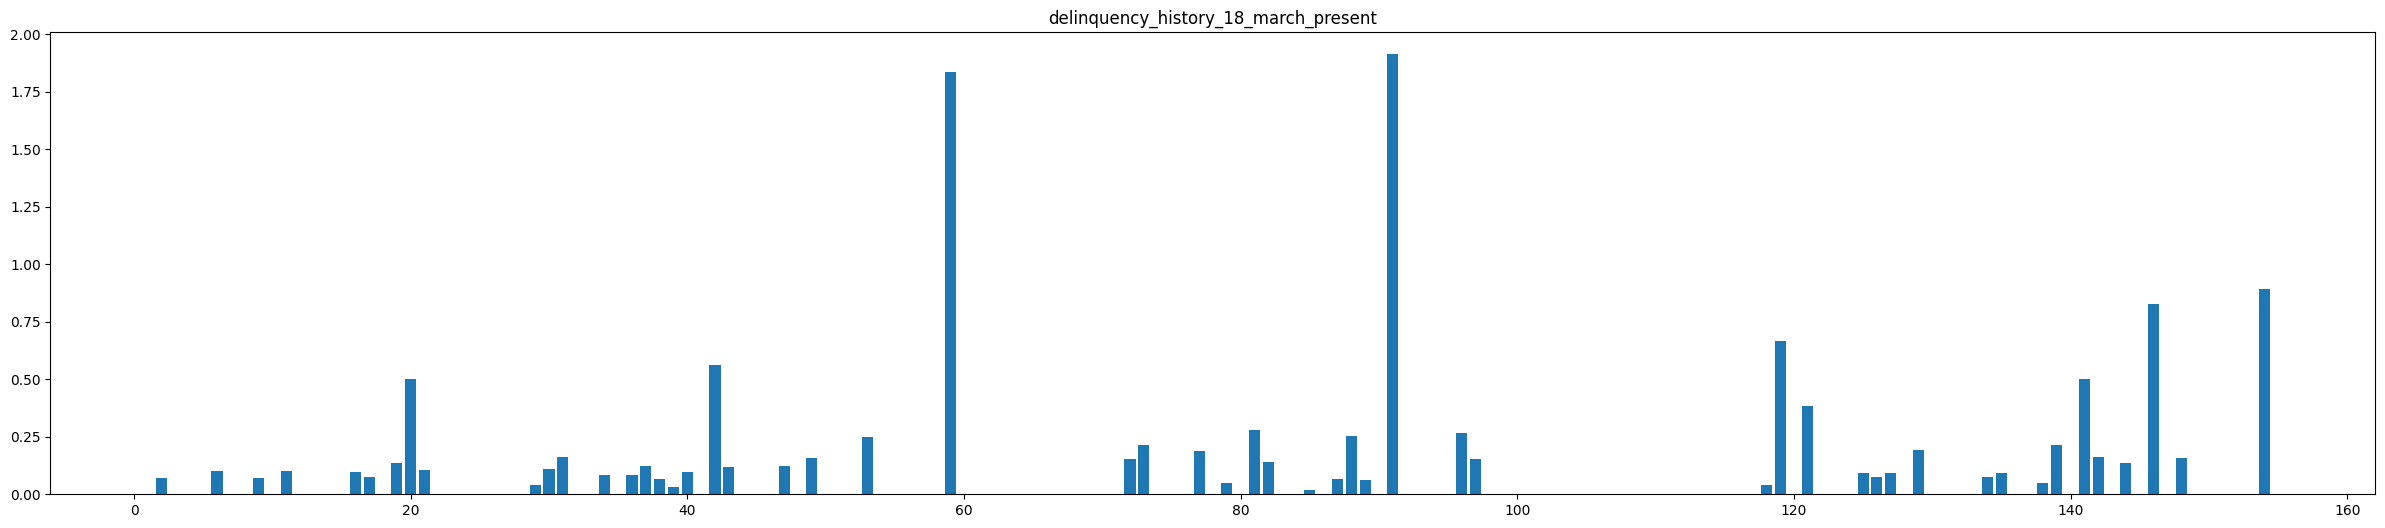

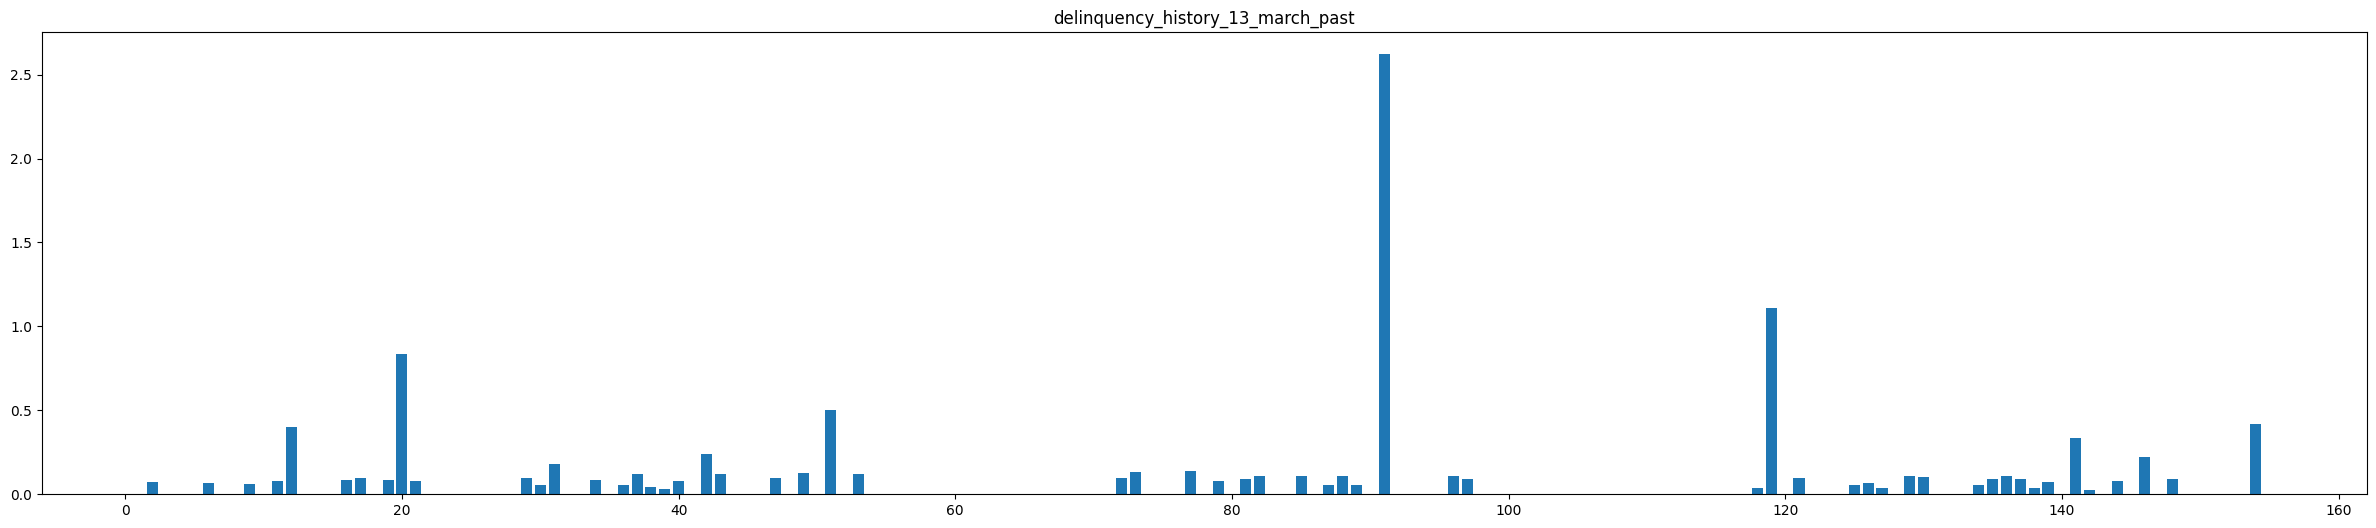

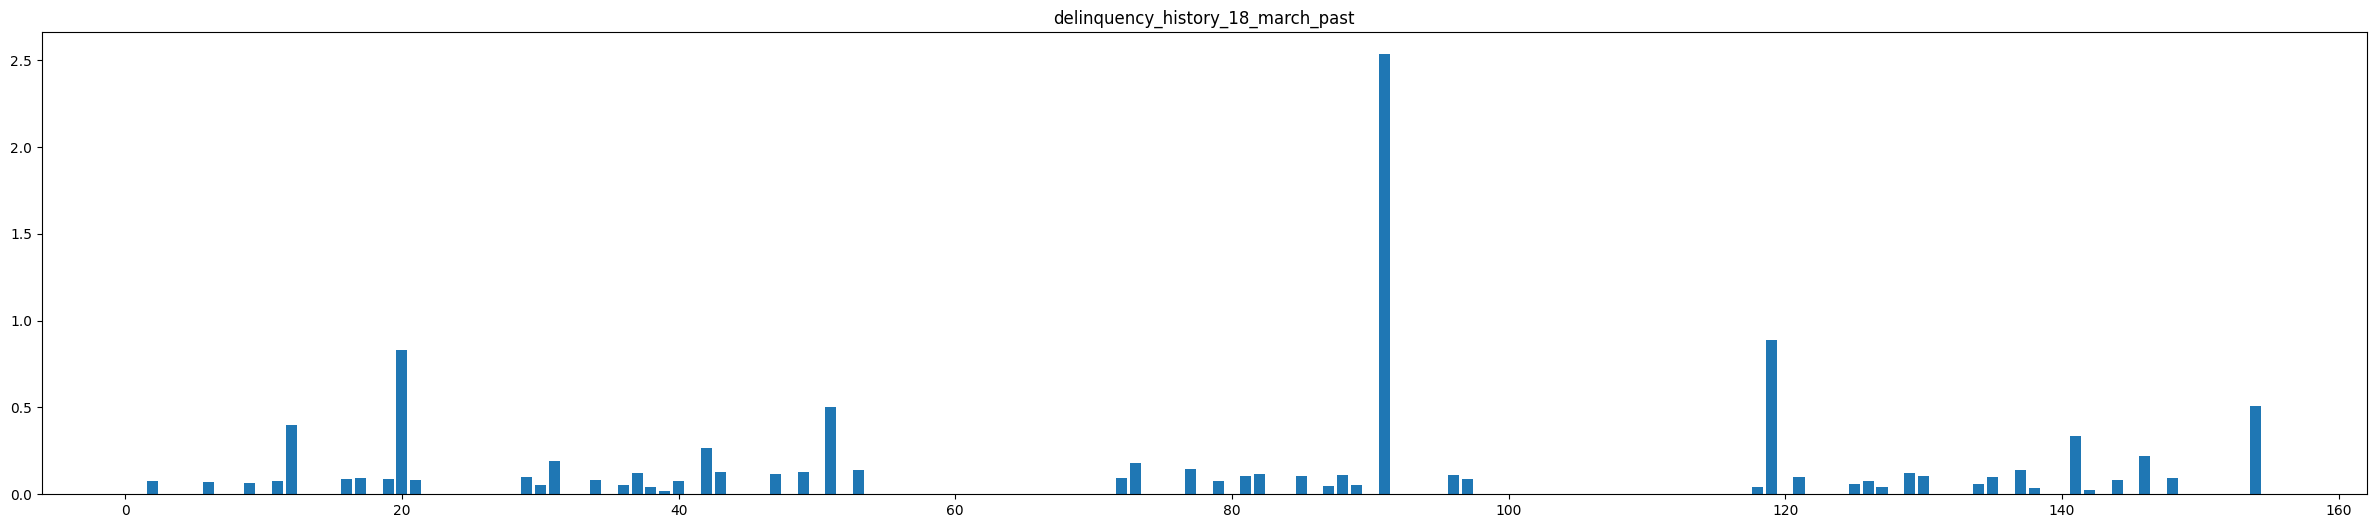

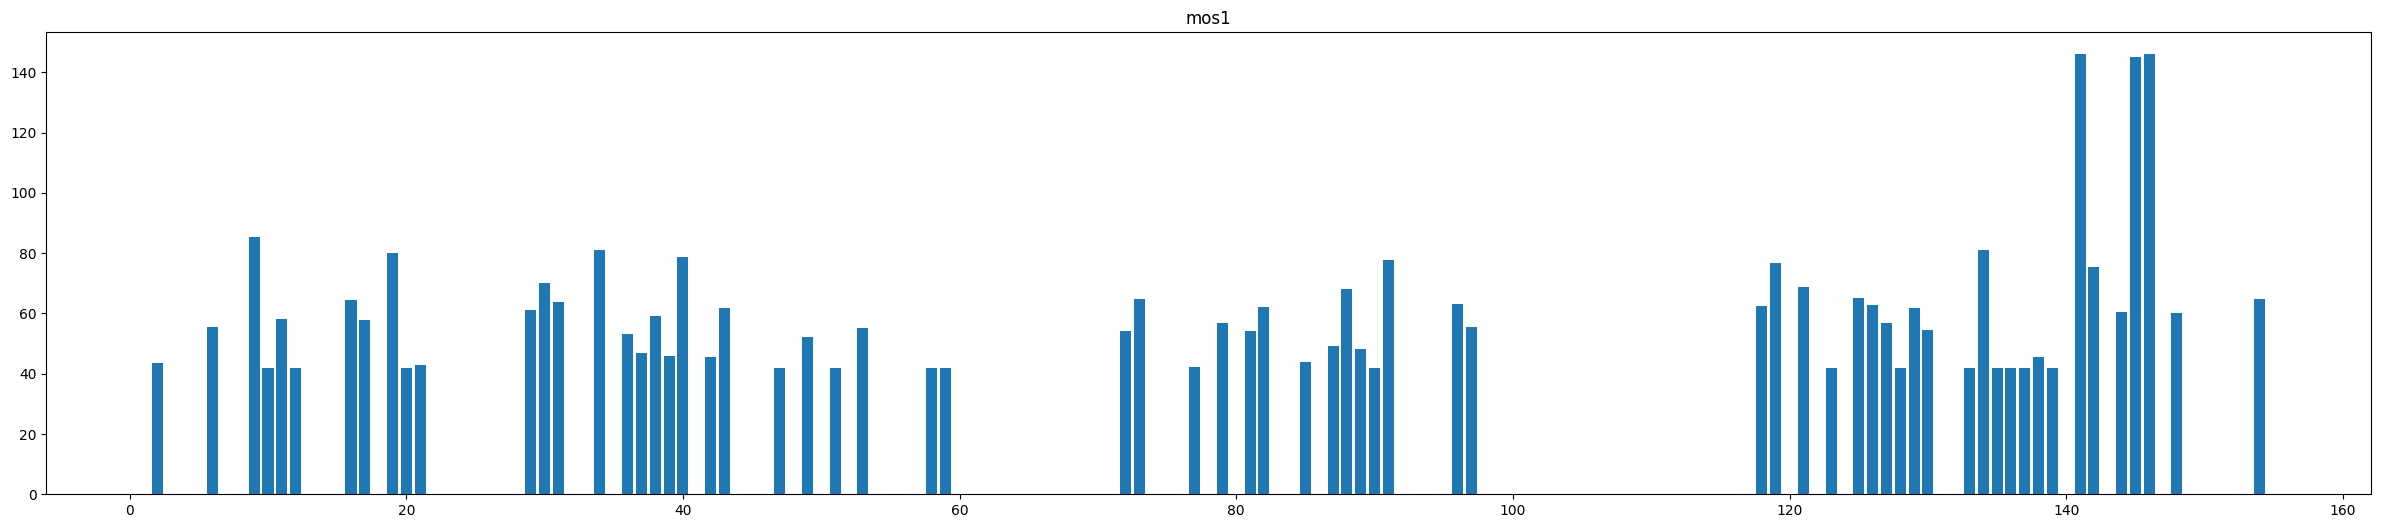

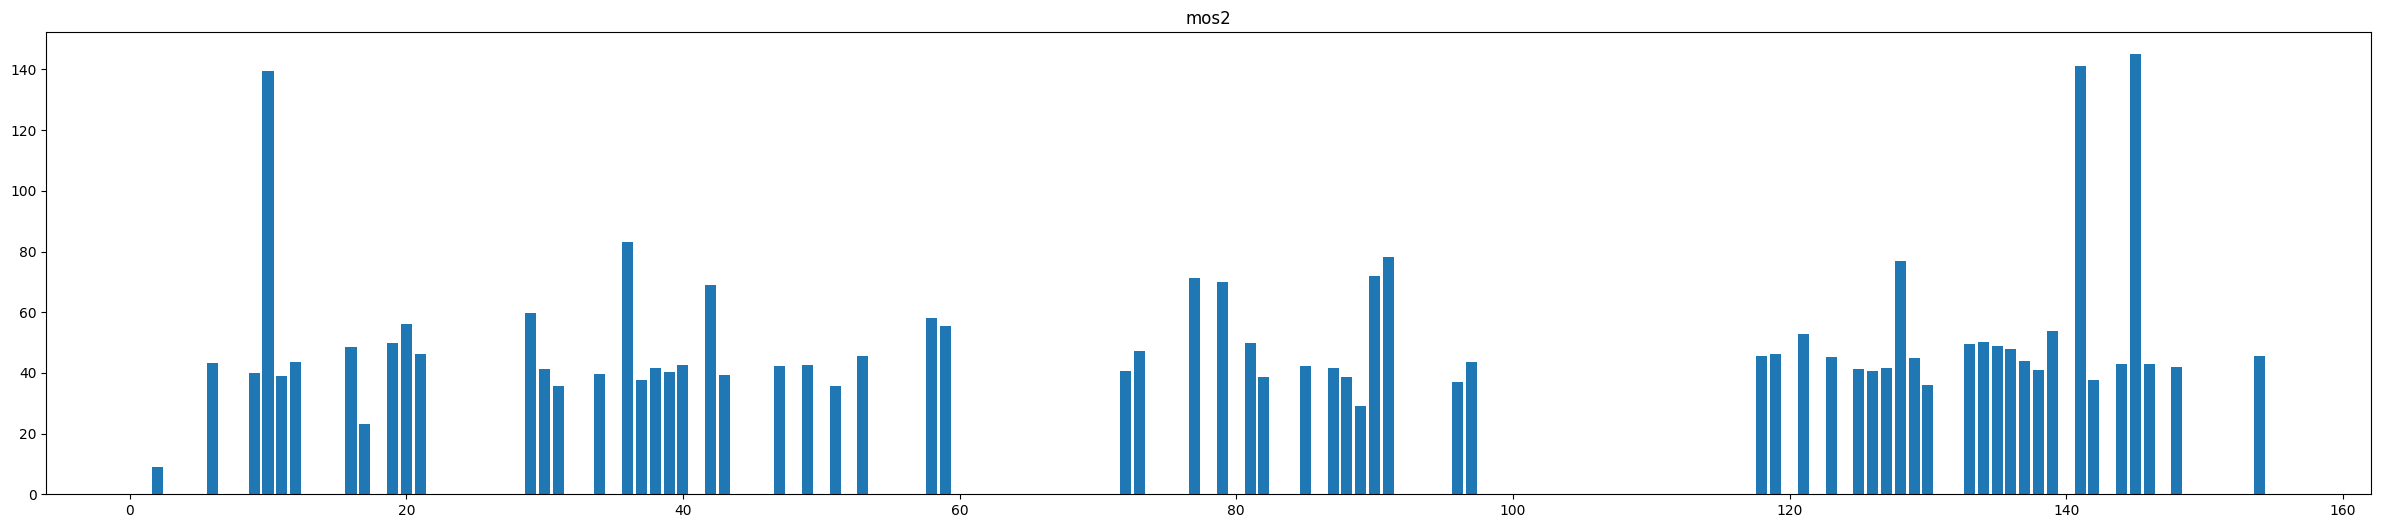

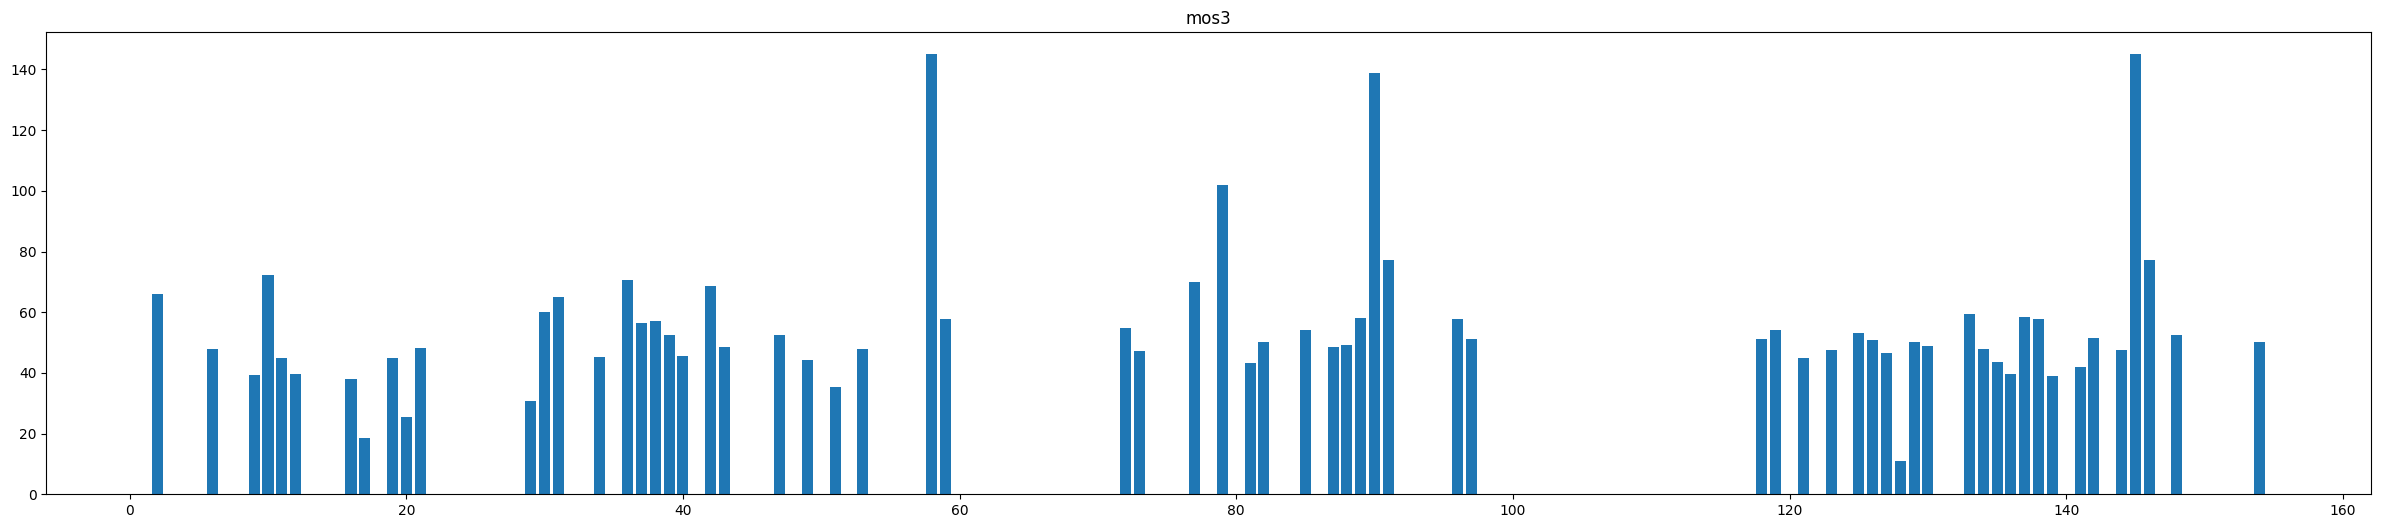

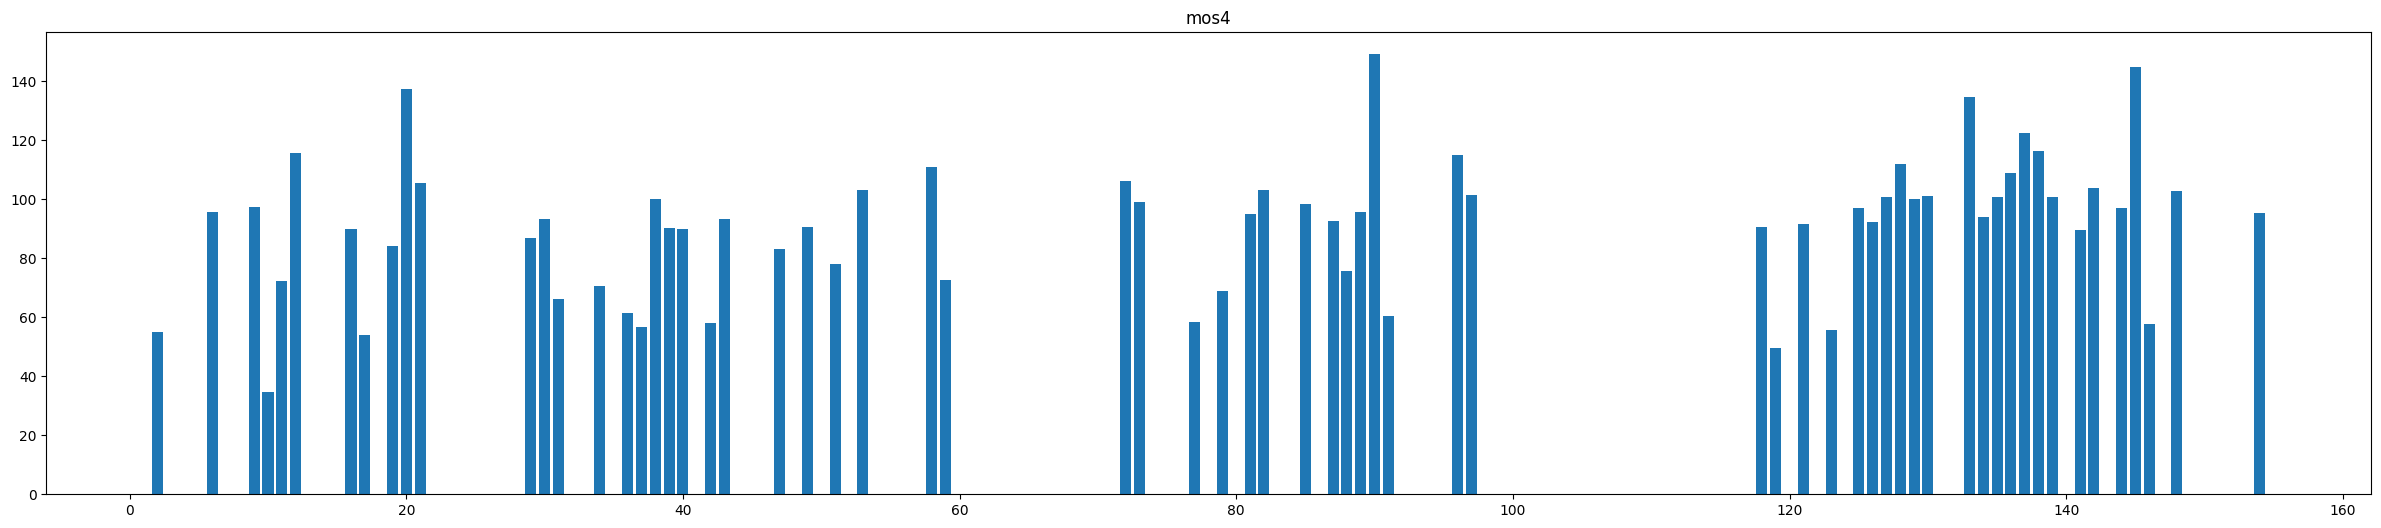

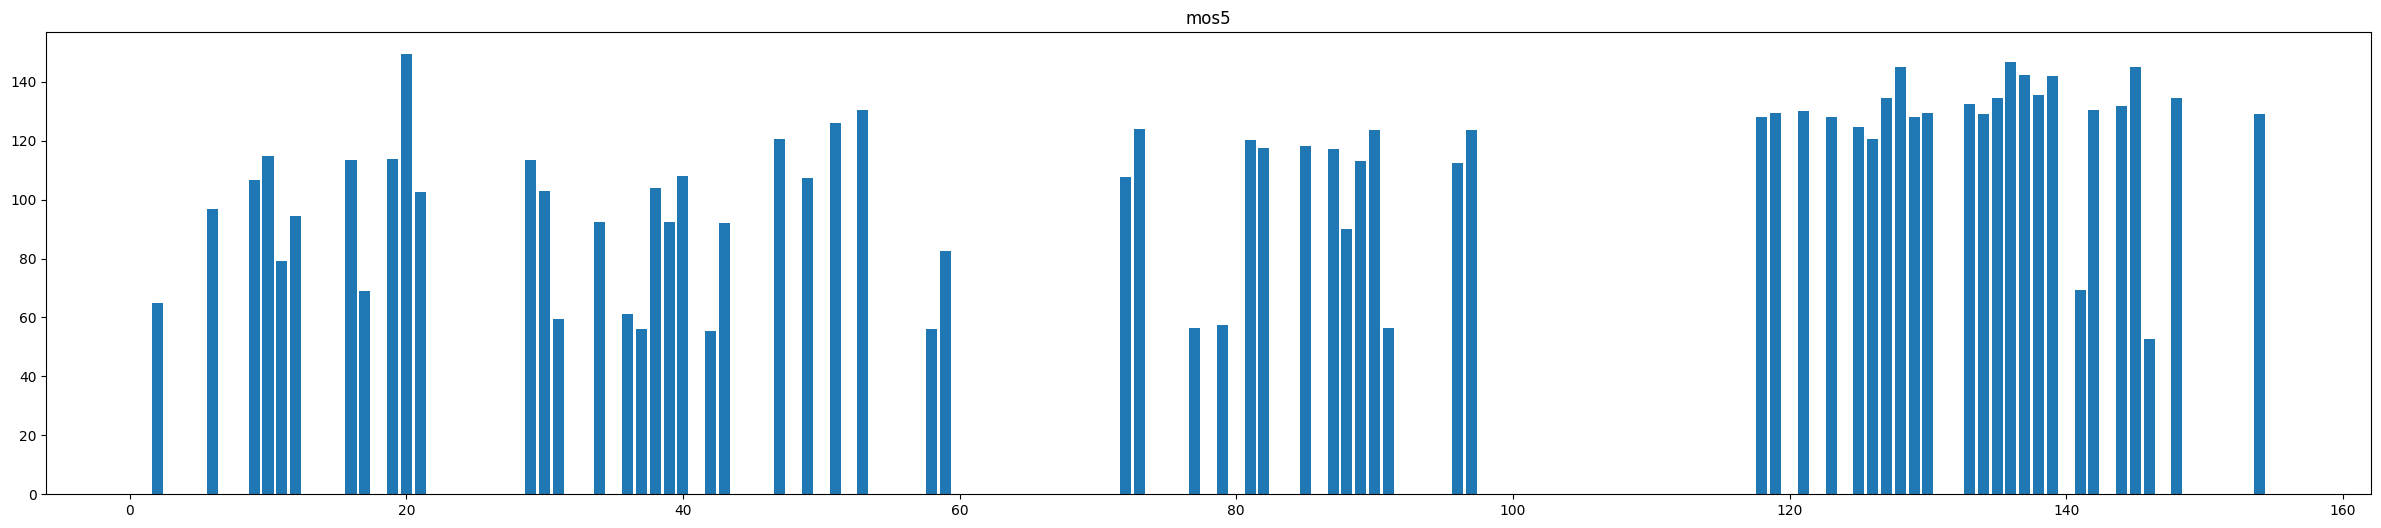

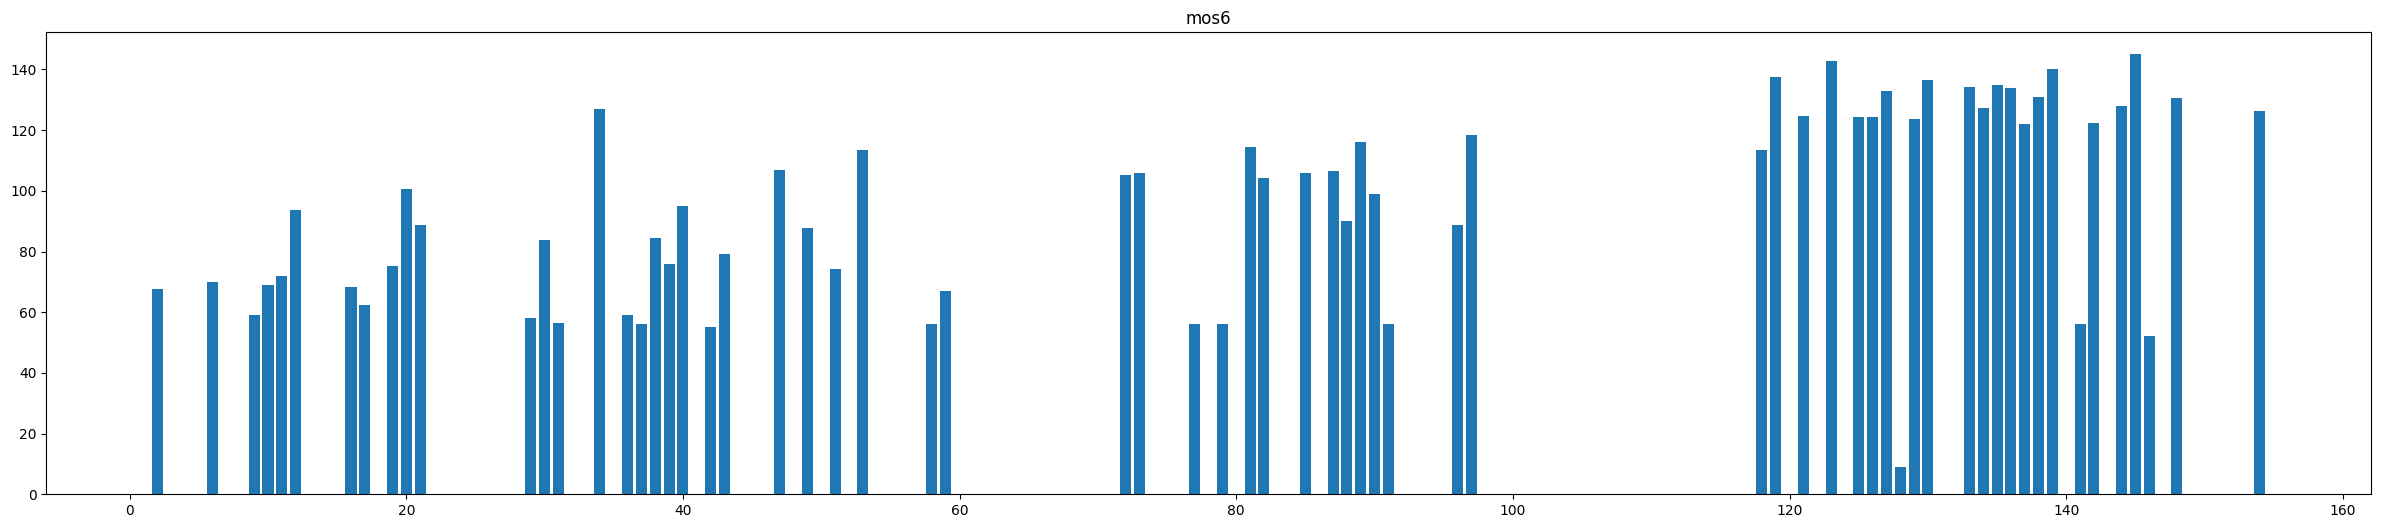

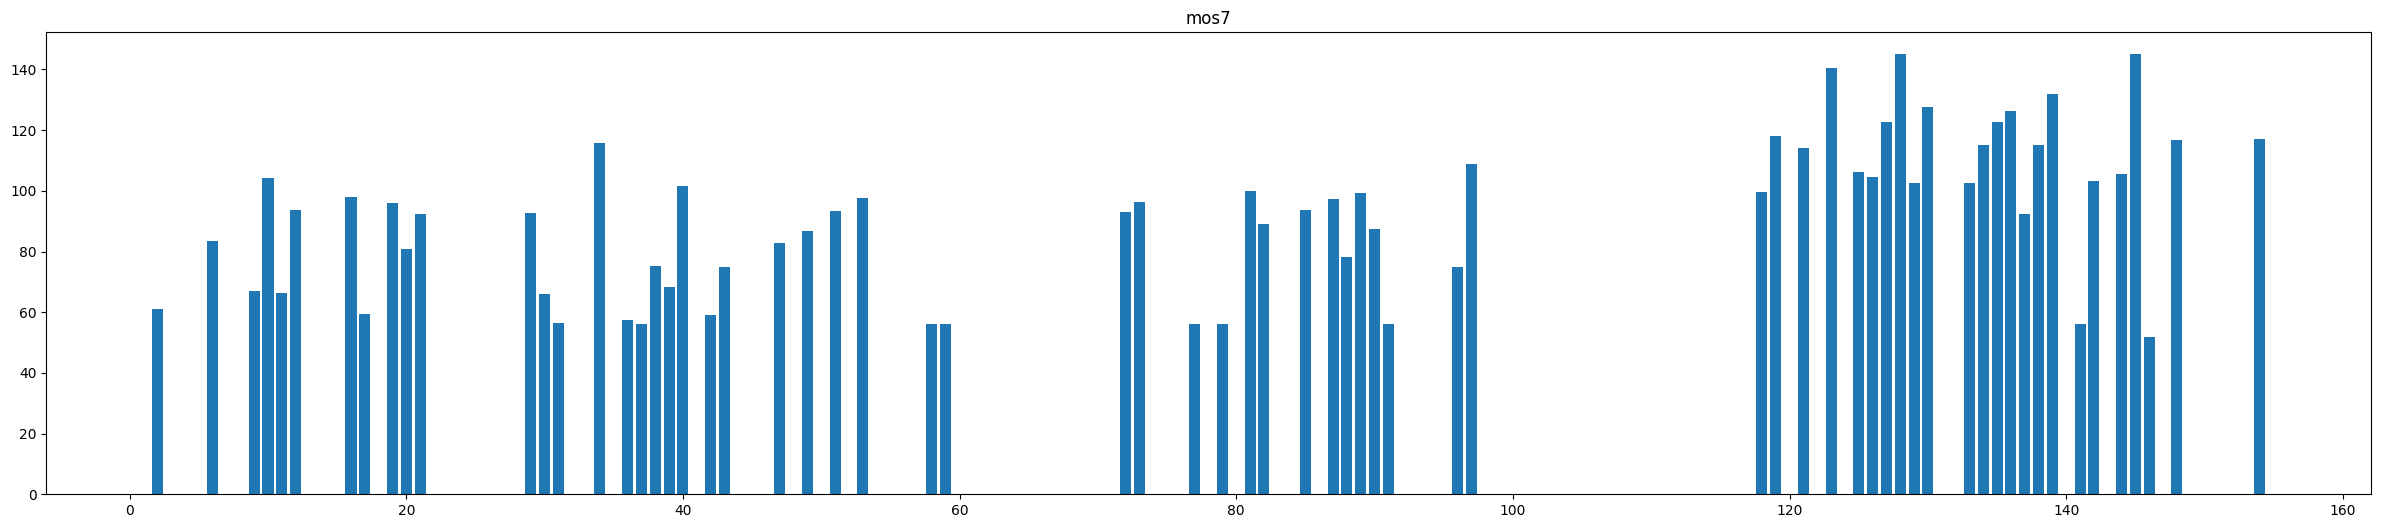

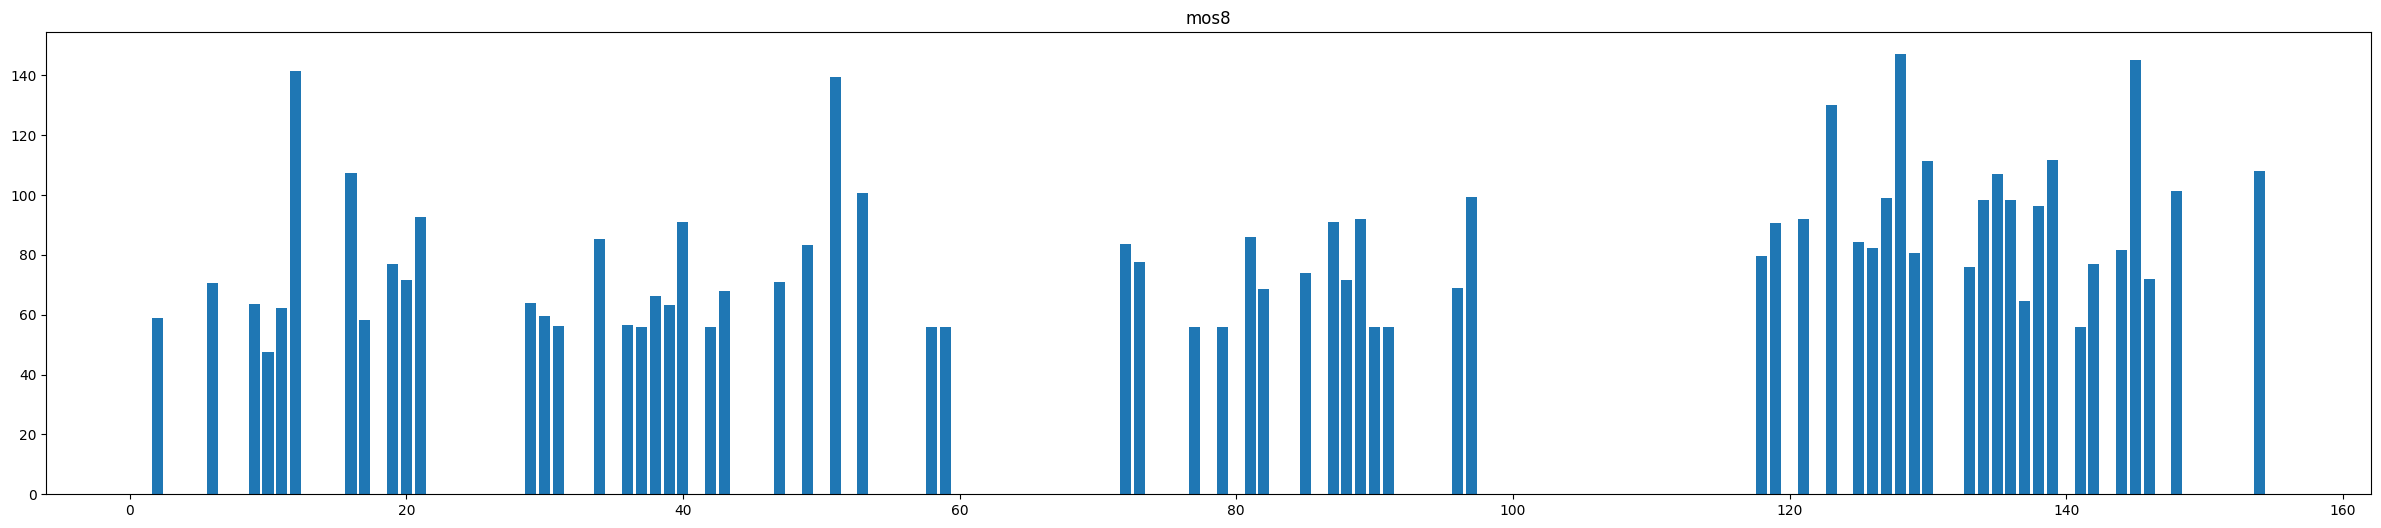

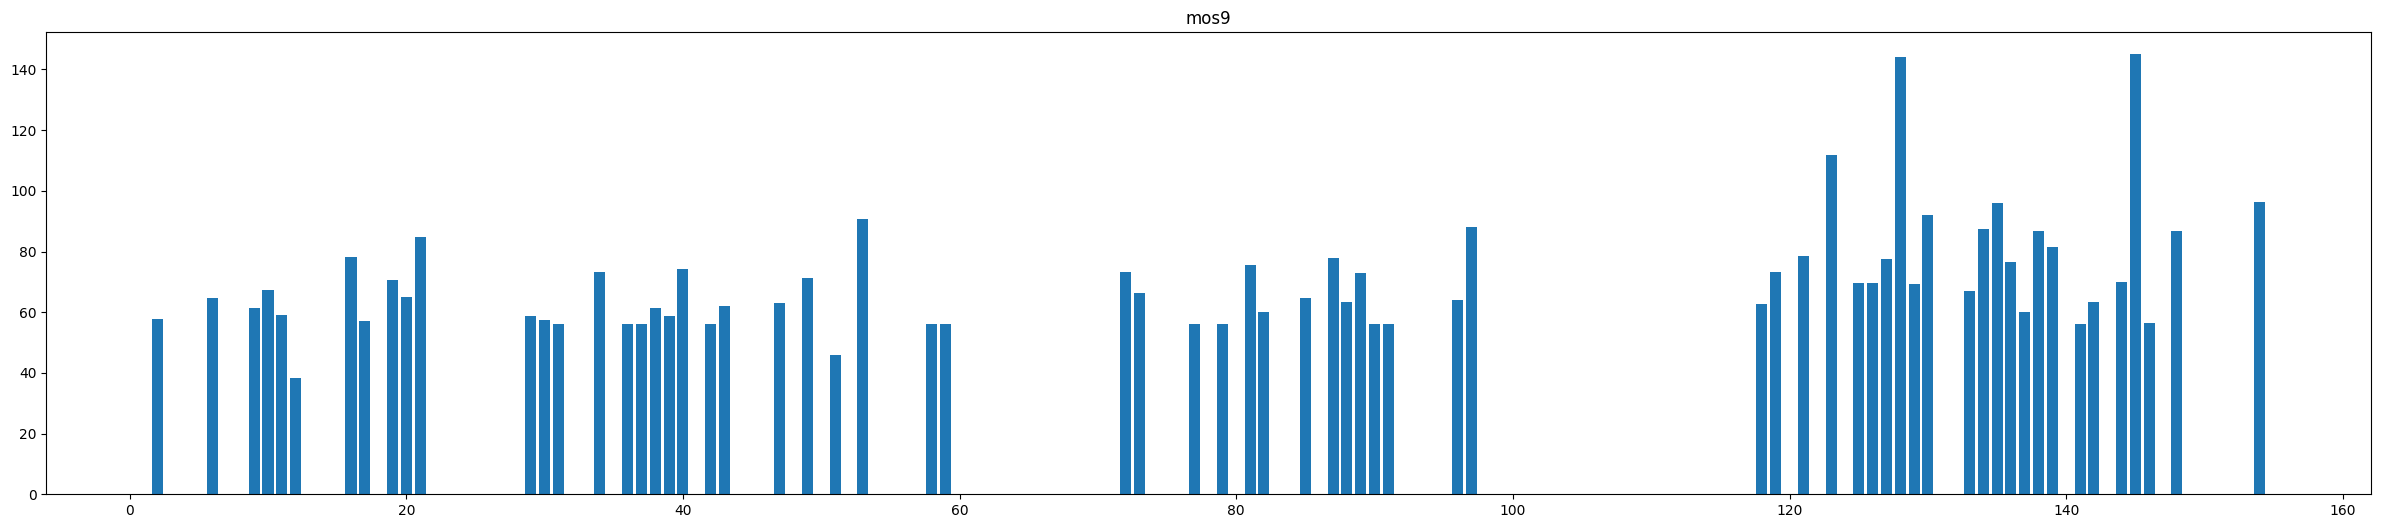

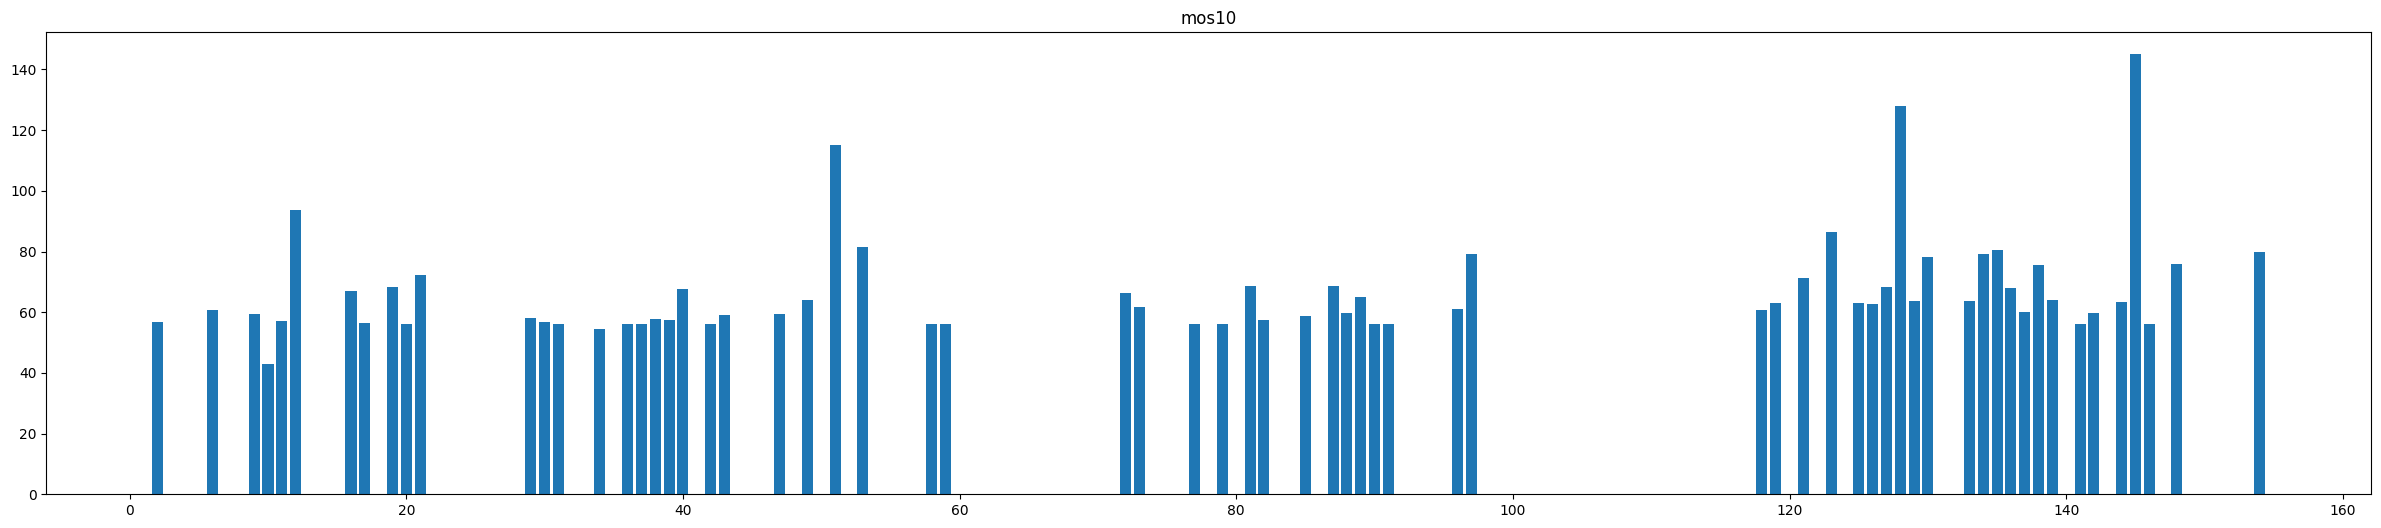

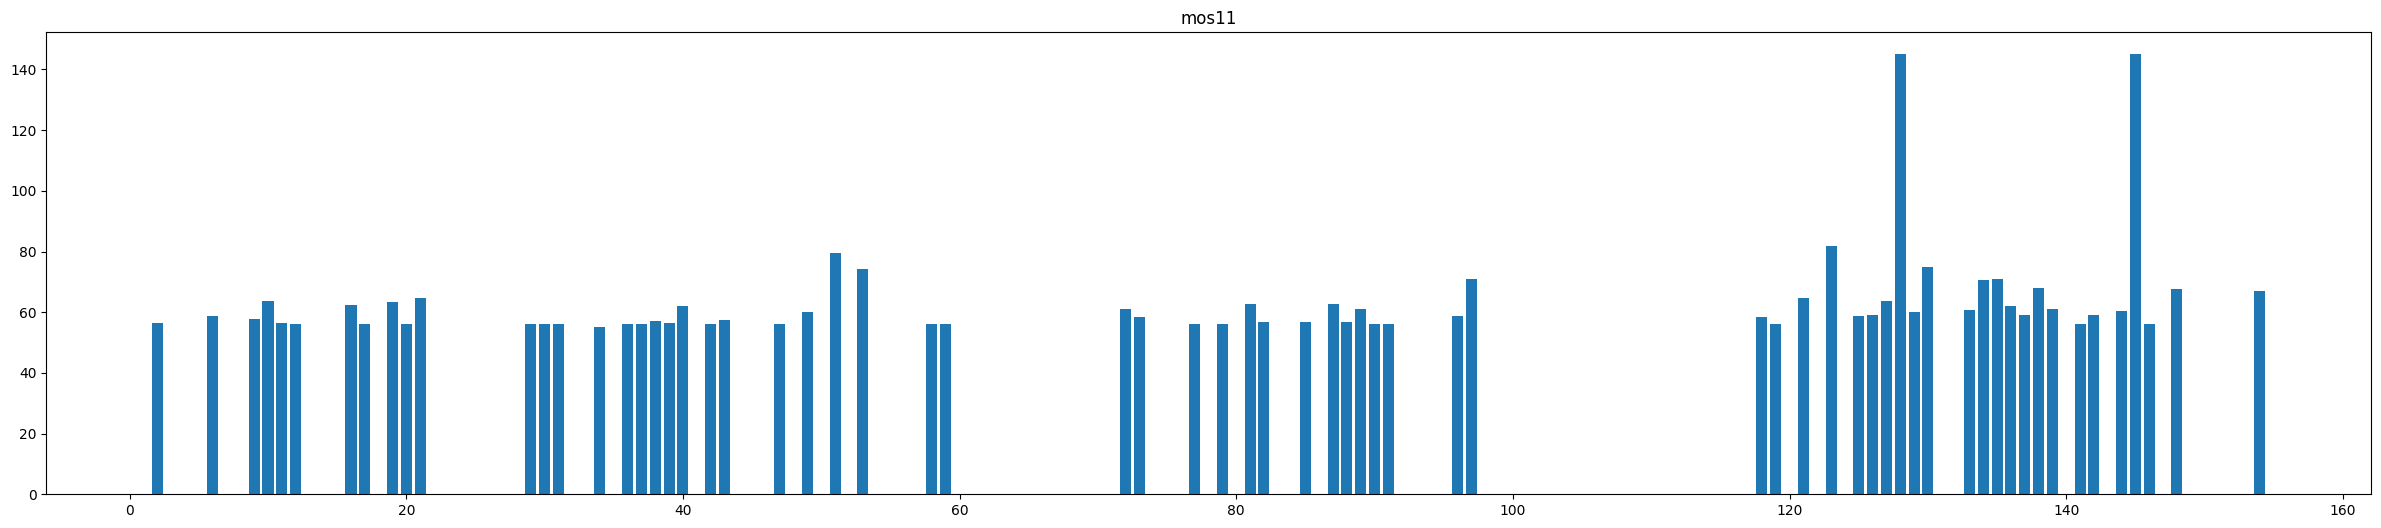

In [8]:
# indices = [f"{index[0]}, {index[1]}" for index in agg_mean.index]
indices = reason_encoder.inverse_transform(agg_mean.index)
for col in agg_mean.columns:
    plt.figure( figsize=(30, 6))
    plt.title(col)
    plt.bar(indices, agg_mean[col])

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [10]:
df = df.drop(["timestamp_call_key", "retailer_code", "mos", "serial"], axis=1)

In [11]:
X = df.drop(['resolved', "mos1", "mos2", "mos3", "mos4", "mos5", "mos6", "mos7", "mos8", "mos9", "mos10", "mos11", "reason"], axis=1)
y = df['resolved']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [13]:
feature_importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
21,time_of_day,0.215700
10,account_open_date_18_march,0.144575
2,account_open_date_13_march,0.143757
9,account_balance_18_march,0.128611
1,account_balance_13_march,0.127237
8,no_of_accounts_with_syf_18_march,0.049217
0,no_of_accounts_with_syf_13_march,0.049151
20,day,0.030823
11,account_status_18_march,0.029362
3,account_status_13_march,0.023994


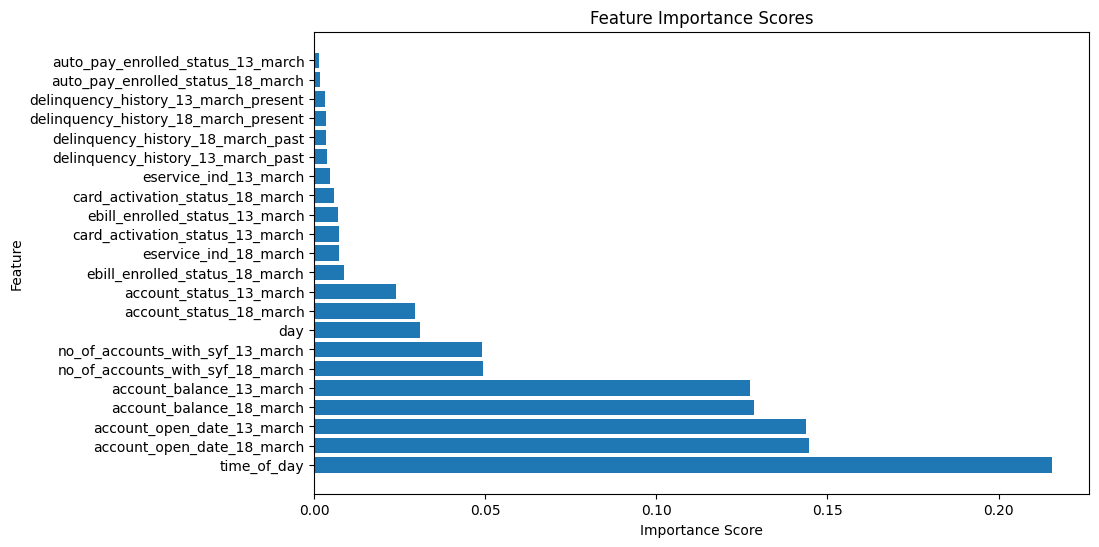

In [14]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance Scores')
plt.show()

In [15]:
pd.DataFrame(reason_encoder.inverse_transform(df["mos6"]), columns=["mos6"]).value_counts()

mos6
NA      1260476
TR       113298
nl       100302
PT        92668
AT        43662
         ...   
BL           10
VP            4
DP            4
ER            2
TE            2
Name: count, Length: 71, dtype: int64

In [16]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = rf_classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.9656436021157705

In [17]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n       False       0.95      0.85      0.90     65594\n        True       0.97      0.99      0.98    296260\n\n    accuracy                           0.97    361854\n   macro avg       0.96      0.92      0.94    361854\nweighted avg       0.97      0.97      0.96    361854\n'